# STD & Me

Analysis of STD prevalence in U.S. counties. Here I start with Chlamydia data from the CDC and add data from the Census Bureau to train a probabilistic model that can predict the Chlamydia rate based on the population characteristics. This model will be used to predict Chlamyida rates in neighborhoods / ZIP code areas for which Census data is available.

In [1]:
# load some libraries we will need
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
# Pandas and Seaborn options

# Always display all the columns
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 200) 

# Plain Seaborn figures with matplotlib color codes mapped to the default seaborn palette 
sns.set(style="white", color_codes=True)

## CDC data on Chlamydia

In [3]:
# read in the csv retrieved from http://gis.cdc.gov/grasp/nchhstpatlas/main.html?value=atlas
df = pd.read_csv("../data/cdc/chlamydia.csv")

Let's explore the dataset by looking at its shape, columns and variable types

In [4]:
df.shape

(3228, 12)

In [5]:
df.columns

Index(['Disease', 'Area', 'State Abbreviation', 'FIPS', 'Year', 'Race', 'Sex', 'Age group', 'Transmission Category', 'Population', 'Cases', 'Rate'], dtype='object')

In [6]:
df.dtypes

Disease                  object
Area                     object
State Abbreviation       object
FIPS                      int64
Year                      int64
Race                     object
Sex                      object
Age group                object
Transmission Category    object
Population               object
Cases                    object
Rate                     object
dtype: object

The object columns actually contain floats and integers. Let's see if we can convert them.

In [7]:
df_test = df.convert_objects(convert_numeric=True)
df_test.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


Disease                   object
Area                      object
State Abbreviation        object
FIPS                       int64
Year                       int64
Race                      object
Sex                       object
Age group                 object
Transmission Category     object
Population               float64
Cases                    float64
Rate                     float64
dtype: object

In [8]:
df_test.head()

,Disease,Area,State Abbreviation,FIPS,Year,Race,Sex,Age group,Transmission Category,Population,Cases,Rate
0,Chlamydia,Autauga County,AL,1001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,NaN,220,398.2
1,Chlamydia,Baldwin County,AL,1003,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,NaN,667,341.1
2,Chlamydia,Barbour County,AL,1005,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,NaN,166,613.1
3,Chlamydia,Bibb County,AL,1007,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,NaN,100,444.2
4,Chlamydia,Blount County,AL,1009,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,NaN,72,124.4


Some numbers have comma separators, which we should remove.

In [9]:
df["Rate"].sort_values()

274                    0.0
2036                   0.0
2385                   0.0
1432                   0.0
941                    0.0
1414                   0.0
2612                   0.0
3136                   0.0
980                    0.0
990                    0.0
96                     0.0
551                    0.0
2656                   0.0
2016                   0.0
2657                   0.0
88                     0.0
2660                   0.0
2676                   0.0
2796                   0.0
1763                   0.0
2542                   0.0
1550                   0.0
278                    0.0
1664                   0.0
1661                   0.0
1659                   0.0
256                    0.0
1694                   0.0
1702                   0.0
1635                   0.0
               ...        
2685                  96.9
1471                 968.1
2026                  97.5
958                   97.6
447                   97.7
3091                 971.7
1

In [10]:
df['Rate'] = df['Rate'].str.replace('Data not available','275.300000')

In [11]:
df['Population'] = df['Population'].str.replace(',','')
df['Cases'] = df['Cases'].str.replace(',','')

In [12]:
df = df.convert_objects(convert_numeric=True)
df.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


Disease                   object
Area                      object
State Abbreviation        object
FIPS                       int64
Year                       int64
Race                      object
Sex                       object
Age group                 object
Transmission Category     object
Population               float64
Cases                    float64
Rate                     float64
dtype: object

In [13]:
df.head()

,Disease,Area,State Abbreviation,FIPS,Year,Race,Sex,Age group,Transmission Category,Population,Cases,Rate
0,Chlamydia,Autauga County,AL,1001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,55246,220,398.2
1,Chlamydia,Baldwin County,AL,1003,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,195540,667,341.1
2,Chlamydia,Barbour County,AL,1005,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,27076,166,613.1
3,Chlamydia,Bibb County,AL,1007,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,22512,100,444.2
4,Chlamydia,Blount County,AL,1009,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,57872,72,124.4


Let's explore a bit more and see what these counties look like

In [14]:
df['Rate'].describe()

count    3151.000000
mean      317.409076
std       187.476039
min         0.000000
25%       184.850000
50%       275.300000
75%       415.250000
max       995.000000
Name: Rate, dtype: float64

That's a wide range of values! Let's make sure this is not just some outlier. 

In [15]:
df['Population'].idxmax()

207

In [16]:
df.loc[207]

Disease                                    Chlamydia
Area                              Los Angeles County
State Abbreviation                                CA
FIPS                                            6037
Year                                            2014
Race                           All races/ethnicities
Sex                                       Both sexes
Age group                             All age groups
Transmission Category    All transmission categories
Population                               1.00171e+07
Cases                                          54881
Rate                                           547.9
Name: 207, dtype: object

It makes sense that LA County is that large. What's the distribution in general?

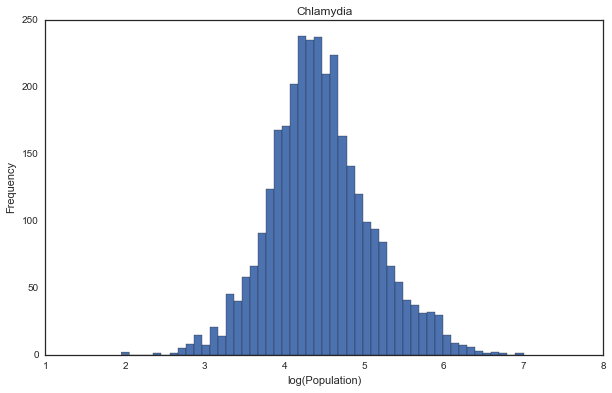

In [17]:
fig = plt.figure(figsize=(10, 6))
data = np.log10(df['Population'])
ax = data.plot.hist(50)
ax.set_xlabel("log(Population)")
ax.set_title("Chlamydia")
plt.savefig('../graphics/county_population_chlamydia.png', bbox_inches='tight', dpi=150)

A log-normal distribution peaking at $10^4$. Looks good so far, but I doubt that there are any cases of Chlamydia in the smallest of counties.

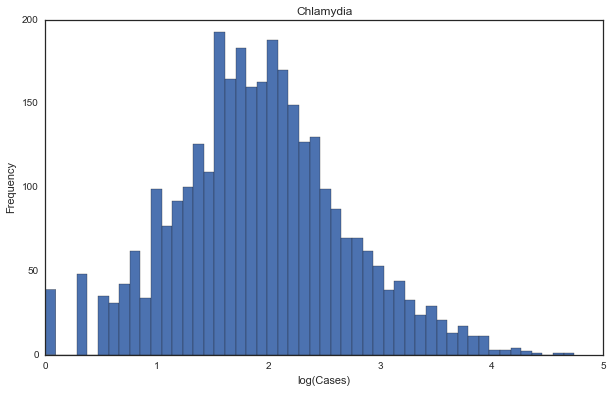

In [18]:
fig = plt.figure(figsize=(10, 6))
data = np.log10(df['Cases']+1)
ax = data.plot.hist(50)
ax.set_xlabel("log(Cases)")
ax.set_title("Chlamydia")
plt.savefig('../graphics/county_cases_chlamydia.png', bbox_inches='tight', dpi=150)

Some of these counties we will have to remove since they will only introduce noise. The question is, should we remove counties with low number of cases or with low rates?

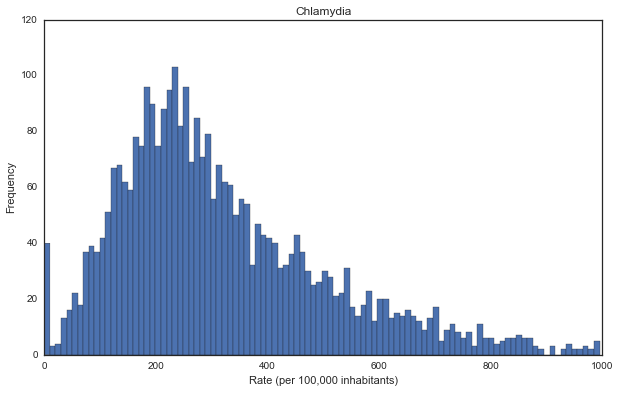

In [19]:
fig = plt.figure(figsize=(10, 6))
ax = df['Rate'].plot.hist(100)
ax.set_xlabel("Rate (per 100,000 inhabitants)")
ax.set_title("Chlamydia")
plt.savefig('../graphics/county_rate_chlamydia.png', bbox_inches='tight', dpi=150)

In [20]:
outliers = df[df['Rate']<50]

In [21]:
len(outliers)

76

Cutting out the low rate one's seems not too bad in term of reduction of data points. But there may be counties with a significant number of cases but many inhabitants, hence low rates. It seems better to cut out the ones with low numbers of reported cases. 

Let's look for missing values, NaN's, zeros, and duplicates.

In [22]:
df["Rate"].sort_values()

96       0
1623     0
2676     0
1731     0
3136     0
2660     0
2657     0
1724     0
2656     0
1414     0
2036     0
2040     0
274      0
1550     0
2542     0
1432     0
1714     0
2612     0
256      0
278      0
980      0
990      0
1628     0
1661     0
2796     0
1659     0
1733     0
1763     0
1748     0
88       0
        ..
1644   NaN
1833   NaN
1983   NaN
1995   NaN
2023   NaN
2032   NaN
2035   NaN
2297   NaN
2335   NaN
2349   NaN
2352   NaN
2356   NaN
2372   NaN
2375   NaN
2379   NaN
2384   NaN
2420   NaN
2424   NaN
2434   NaN
2539   NaN
2926   NaN
2927   NaN
2930   NaN
2933   NaN
2942   NaN
2944   NaN
2946   NaN
2947   NaN
2948   NaN
3090   NaN
Name: Rate, dtype: float64

We definitely want to remove those NaN's later!

How about unique values/duplicates?

In [23]:
len(df['Area'].unique())

1962

Why are there only 1962 unique counties?

In [24]:
df.shape

(3228, 12)

In [25]:
df.sort_values(by='Area')

,Disease,Area,State Abbreviation,FIPS,Year,Race,Sex,Age group,Transmission Category,Population,Cases,Rate
2319,Chlamydia,Abbeville County,SC,45001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,25007,117,467.9
1116,Chlamydia,Acadia Parish,LA,22001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,62204,285,458.2
2823,Chlamydia,Accomack County,VA,51001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,33148,262,790.4
554,Chlamydia,Ada County,ID,16001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,416464,1529,367.1
996,Chlamydia,Adair County,KY,21001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,18732,46,245.6
1486,Chlamydia,Adair County,MO,29001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,25572,70,273.7
792,Chlamydia,Adair County,IA,19001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,7472,7,93.7
2134,Chlamydia,Adair County,OK,40001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,22194,128,576.7
1657,Chlamydia,Adams County,NE,31001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,31610,87,275.2
700,Chlamydia,Adams County,IN,18001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,34614,43,124.2


In [26]:
df['Area'].value_counts()

Washington County         30
Jefferson County          25
Franklin County           24
Jackson County            23
Lincoln County            23
Madison County            19
Montgomery County         18
Clay County               18
Union County              17
Monroe County             17
Marion County             17
Wayne County              16
Grant County              14
Warren County             14
Greene County             14
Carroll County            13
Lake County               12
Douglas County            12
Polk County               12
Adams County              12
Johnson County            12
Lee County                12
Clark County              12
Marshall County           12
Morgan County             11
Crawford County           11
Lawrence County           11
Scott County              11
Fayette County            11
Calhoun County            11
                          ..
San Saba County            1
Winn Parish                1
Sitka City and Borough     1
Idaho County  

That makes sense now. Good that we have the FIPS number, which gives all of these counties unique identifiers.

Let's check for nulls.

In [27]:
df.isnull().values.any()

True

We can remove those entries and create a new, completely clean dataframe

In [28]:
null_list = df["Population"].isnull()
not_null_list = [not i for i in null_list]
df_clean = df[not_null_list].copy()

In [29]:
null_list = df_clean["Rate"].isnull()
not_null_list = [not i for i in null_list]
df_completely_clean = df_clean[not_null_list].copy()

In [30]:
df_completely_clean.isnull().values.any()

False

## Get ZIP codes and FIPS codes for counties

We will need a mapping function for ZIP codes and for FIPS codes. ZIP codes are used by USPS and are generally known by the users, whereas governmental studies and CDC data usually use FIPS codes for regions. 

The CDC provides csv files with conversions for both directions. We just have to create two dictionaries to go from ZIP code to FIPS and vice versa.

In [31]:
df_fipszip= pd.read_csv("../data/COUNTY_ZIP_122014.csv", usecols={0,1})

In [32]:
df_fipszip.shape

(51280, 2)

In [33]:
df_fipszip.head()

,COUNTY,ZIP
0,1001,36051
1,1001,36066
2,1001,36703
3,1001,36068
4,1001,36749


In [34]:
df_zipfips= pd.read_csv("../data/ZIP_COUNTY_122014.csv", usecols={0,1})

In [35]:
df_zipfips.shape

(51280, 2)

In [36]:
df_zipfips.head()

,ZIP,COUNTY
0,501,36103
1,601,72001
2,602,72003
3,603,72005
4,604,72005


In [37]:
df_zipfips.dtypes

ZIP       int64
COUNTY    int64
dtype: object

There are 51280 ZIP codes in these two tables, compared to the 3143 counties. Going from ZIP code to FIPS code will be easy:

In [38]:
zip2fips = dict(zip(df_zipfips["ZIP"], df_zipfips["COUNTY"]))

In [39]:
zip2fips[2139]

25017

Going from FIPS to ZIP code will be a bit more complicated since each FIPS contains many ZIPs.

In [40]:
fips2zip = {}

In [41]:
for fips in np.arange(len(df_fipszip.COUNTY)):
    if df_fipszip.COUNTY[fips] in fips2zip:
        fips2zip[df_fipszip.COUNTY[fips]].append(df_fipszip.ZIP[fips])
    else:
        fips2zip[df_fipszip.COUNTY[fips]] = []
        fips2zip[df_fipszip.COUNTY[fips]].append(df_fipszip.ZIP[fips])

In [42]:
len(fips2zip[25017])

107

In [43]:
df_fipszip.COUNTY[1]

1001

In [44]:
fips2zip[zip2fips[754]]

[754]

In [45]:
df_fipszip['COUNTY'].value_counts()

6037     498
48201    229
17031    225
11001    219
4013     193
6073     178
6059     145
42003    144
48113    140
36061    135
12086    122
6071     122
53033    119
32003    114
36103    111
25017    107
9003     107
6085     106
48439    104
48029    104
6065     104
6019     103
25027    102
42129     94
42091     92
48453     90
26125     90
36029     90
1073      88
12057     87
        ... 
72129      1
72019      1
51515      1
31007      1
48261      1
31117      1
72065      1
72121      1
72125      1
72093      1
51720      1
72027      1
35028      1
48431      1
72045      1
48155      1
51530      1
48271      1
51580      1
48413      1
72051      1
72095      1
72143      1
48137      1
72111      1
48301      1
72079      1
72059      1
72047      1
72043      1
Name: COUNTY, dtype: int64

That's quite remarkable. Some counties contain several hundred ZIP codes! LA County has the most of course.

## Census data for counties

The Census Bureau offers tons of data on county level:

http://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml

I pre-selected a few tables that seem most relevant in terms of population characteristics. Other tables can be added later. Most importantly, the tables should also be available on ZIP code level for prediction later on. That's not the case for many of the tables.

In [46]:
df_census = pd.read_csv("../data/census/DEC_10_general.csv", header=0, skiprows={1})
df_census_labels = pd.read_csv("../data/census/DEC_10_general_metadata.csv", header=0, nrows=1)

In [47]:
df_census.shape, df_census_labels.shape

((3143, 375), (1, 2))

In [48]:
df_census.head()

,GEO.id,GEO.id2,GEO.display-label,HD01_S001,HD02_S001,HD01_S002,HD02_S002,HD01_S003,HD02_S003,HD01_S004,HD02_S004,HD01_S005,HD02_S005,HD01_S006,HD02_S006,HD01_S007,HD02_S007,HD01_S008,HD02_S008,HD01_S009,HD02_S009,HD01_S010,HD02_S010,HD01_S011,HD02_S011,HD01_S012,HD02_S012,HD01_S013,HD02_S013,HD01_S014,HD02_S014,HD01_S015,HD02_S015,HD01_S016,HD02_S016,HD01_S017,HD02_S017,HD01_S018,HD02_S018,HD01_S019,HD02_S019,HD01_S020,HD02_S020,HD01_S021,HD02_S021,HD01_S022,HD02_S022,HD01_S023,HD02_S023,HD01_S024,HD02_S024,HD01_S025,HD02_S025,HD01_S026,HD02_S026,HD01_S027,HD02_S027,HD01_S028,HD02_S028,HD01_S029,HD02_S029,HD01_S030,HD02_S030,HD01_S031,HD02_S031,HD01_S032,HD02_S032,HD01_S033,HD02_S033,HD01_S034,HD02_S034,HD01_S035,HD02_S035,HD01_S036,HD02_S036,HD01_S037,HD02_S037,HD01_S038,HD02_S038,HD01_S039,HD02_S039,HD01_S040,HD02_S040,HD01_S041,HD02_S041,HD01_S042,HD02_S042,HD01_S043,HD02_S043,HD01_S044,HD02_S044,HD01_S045,HD02_S045,HD01_S046,HD02_S046,HD01_S047,HD02_S047,HD01_S048,HD02_S048,HD01_S049,...,HD01_S137,HD02_S137,HD01_S138,HD02_S138,HD01_S139,HD02_S139,HD01_S140,HD02_S140,HD01_S141,HD02_S141,HD01_S142,HD02_S142,HD01_S143,HD02_S143,HD01_S144,HD02_S144,HD01_S145,HD02_S145,HD01_S146,HD02_S146,HD01_S147,HD02_S147,HD01_S148,HD02_S148,HD01_S149,HD02_S149,HD01_S150,HD02_S150,HD01_S151,HD02_S151,HD01_S152,HD02_S152,HD01_S153,HD02_S153,HD01_S154,HD02_S154,HD01_S155,HD02_S155,HD01_S156,HD02_S156,HD01_S157,HD02_S157,HD01_S158,HD02_S158,HD01_S159,HD02_S159,HD01_S160,HD02_S160,HD01_S161,HD02_S161,HD01_S162,HD02_S162,HD01_S163,HD02_S163,HD01_S164,HD02_S164,HD01_S165,HD02_S165,HD01_S166,HD02_S166,HD01_S167,HD02_S167,HD01_S168,HD02_S168,HD01_S169,HD02_S169,HD01_S170,HD02_S170,HD01_S171,HD02_S171,HD01_S172,HD02_S172,HD01_S173,HD02_S173,HD01_S174,HD02_S174,HD01_S175,HD02_S175,HD01_S176,HD02_S176,HD01_S177,HD02_S177,HD01_S178,HD02_S178,HD01_S179,HD02_S179,HD01_S180,HD02_S180,HD01_S181,HD02_S181,HD01_S182,HD02_S182,HD01_S183,HD02_S183,HD01_S184,HD02_S184,HD01_S185,HD02_S185,HD01_S186,HD02_S186
0,0500000US01001,1001,"Autauga County, Alabama",54571,100,3579,6.6,3991,7.3,4290,7.9,4290,7.9,3080,5.6,3157,5.8,3330,6.1,4157,7.6,4086,7.5,4332,7.9,3873,7.1,3083,5.6,2777,5.1,2277,4.2,1736,3.2,1251,2.3,731,1.3,551,1.0,37.0,( X ),41804,76.6,39958,73.2,37756,69.2,8222,15.1,6546,12.0,26569,48.7,1866,3.4,2001,3.7,2171,4.0,2213,4.1,1539,2.8,1543,2.8,1594,2.9,2004,3.7,1974,3.6,2174,4.0,1866,3.4,1524,2.8,1279,2.3,1014,1.9,807,1.5,546,1.0,295,0.5,159,0.3,35.9,( X ),20046,36.7,19114,35.0,17968,32.9,3606,...,1551,2.8,425,0.8,1859,3.4,167,0.3,75,0.1,882,1.6,455,0.8,362,0.7,194,0.4,168,0.3,93,0.2,62,0.1,31,0.1,20221,100,15064,74.5,7065,34.9,11367,56.2,5110,25.3,934,4.6,474,2.3,2763,13.7,1481,7.3,5157,25.5,4441,22.0,2012,10.0,417,2.1,2429,12.0,1187,5.9,7972,39.4,4733,23.4,2.68,( X ),3.13,( X ),22135,100,20221,91.4,1914,8.6,429,1.9,30,0.1,305,1.4,62,0.3,266,1.2,822,3.7,2.0,( X ),7.9,( X ),20221,100,15248,75.4,40942,( X ),2.69,( X ),4973,24.6,13174,( X ),2.65,( X )
1,0500000US01003,1003,"Baldwin County, Alabama",182265,100,11158,6.1,11599,6.4,11926,6.5,11600,6.4,9449,5.2,10247,5.6,10709,5.9,11558,6.3,11995,6.6,13431,7.4,13490,7.4,12523,6.9,12012,6.6,10174,5.6,7629,4.2,5598,3.1,3934,2.2,3233,1.8,41.1,( X ),145215,79.7,140367,77.0,134024,73.5,37780,20.7,30568,16.8,89196,48.9,5614,3.1,5832,3.2,6076,3.3,5930,3.3,4793,2.6,5183,2.8,5317,2.9,5725,3.1,5895,3.2,6622,3.6,6425,3.5,5943,3.3,5728,3.1,4895,2.7,3663,2.0,2644,1.5,1735,1.0,1176,0.6,40.1,( X ),70491,38.7,67970,37.3,64731,35.5,17540,...,4542,2.5,1356,0.7,7931,4.4,651,0.4,427,0.2,3686,2.0,2307,1.3,1744,1.0,1282,0.7,462,0.3,563,0.3,259,0.1,304,0.2,73180,100,51151,69.9,20472,28.0,39913,54.5,14559,19.9,3094,4.2,1558,2.1,8144,11.1,4355,6.0,22029,30.1,18372,25.1,8096,11.1,2159,3.0,10276,14.0,5269,7.2,23224,31.7,21733,29.7,2.46,( X ),2.93,( X ),104061,100,73180,70.3,30881,29.7,7822,7.5,188,0.2,2837,2.7,343,0.3,16931,16.3,2760,2.7,5.0,( X ),27.8,( X ),73180,100,53071,72.5,131251,( X ),2.47,( X ),20109,27.5,48707,( X ),2.42,( X )
2,0

We will be facing the same problems as with the CDC data. The columns have to be converted to a proper format.

In [49]:
df_census.convert_objects(convert_numeric=True)
df_census.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


GEO.id                object
GEO.id2                int64
GEO.display-label     object
HD01_S001             object
HD02_S001              int64
HD01_S002              int64
HD02_S002            float64
HD01_S003              int64
HD02_S003            float64
HD01_S004              int64
HD02_S004            float64
HD01_S005              int64
HD02_S005            float64
HD01_S006              int64
HD02_S006            float64
HD01_S007              int64
HD02_S007            float64
HD01_S008              int64
HD02_S008            float64
HD01_S009              int64
HD02_S009            float64
HD01_S010              int64
HD02_S010            float64
HD01_S011              int64
HD02_S011            float64
HD01_S012              int64
HD02_S012            float64
HD01_S013              int64
HD02_S013            float64
HD01_S014              int64
                      ...   
HD01_S172              int64
HD02_S172            float64
HD01_S173              int64
HD02_S173     

For SQL purposes, I will remove all special characters and capital letters from the column names. This will make life a lot easier later on.

In [50]:
columnnames = list(df_census.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)
    df_census_labels.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

geoid
geoid2
geodisplaylabel
hd01s001
hd02s001
hd01s002
hd02s002
hd01s003
hd02s003
hd01s004
hd02s004
hd01s005
hd02s005
hd01s006
hd02s006
hd01s007
hd02s007
hd01s008
hd02s008
hd01s009
hd02s009
hd01s010
hd02s010
hd01s011
hd02s011
hd01s012
hd02s012
hd01s013
hd02s013
hd01s014
hd02s014
hd01s015
hd02s015
hd01s016
hd02s016
hd01s017
hd02s017
hd01s018
hd02s018
hd01s019
hd02s019
hd01s020
hd02s020
hd01s021
hd02s021
hd01s022
hd02s022
hd01s023
hd02s023
hd01s024
hd02s024
hd01s025
hd02s025
hd01s026
hd02s026
hd01s027
hd02s027
hd01s028
hd02s028
hd01s029
hd02s029
hd01s030
hd02s030
hd01s031
hd02s031
hd01s032
hd02s032
hd01s033
hd02s033
hd01s034
hd02s034
hd01s035
hd02s035
hd01s036
hd02s036
hd01s037
hd02s037
hd01s038
hd02s038
hd01s039
hd02s039
hd01s040
hd02s040
hd01s041
hd02s041
hd01s042
hd02s042
hd01s043
hd02s043
hd01s044
hd02s044
hd01s045
hd02s045
hd01s046
hd02s046
hd01s047
hd02s047
hd01s048
hd02s048
hd01s049
hd02s049
hd01s050
hd02s050
hd01s051
hd02s051
hd01s052
hd02s052
hd01s053
hd02s053
hd01s054
hd02s054

In [51]:
df_census_clean = df_census.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid               object
geoid2               int64
geodisplaylabel     object
hd01s001             int64
hd02s001             int64
hd01s002             int64
hd02s002           float64
hd01s003             int64
hd02s003           float64
hd01s004             int64
hd02s004           float64
hd01s005             int64
hd02s005           float64
hd01s006             int64
hd02s006           float64
hd01s007             int64
hd02s007           float64
hd01s008             int64
hd02s008           float64
hd01s009             int64
hd02s009           float64
hd01s010             int64
hd02s010           float64
hd01s011             int64
hd02s011           float64
hd01s012             int64
hd02s012           float64
hd01s013             int64
hd02s013           float64
hd01s014             int64
                    ...   
hd01s172             int64
hd02s172           float64
hd01s173             int64
hd02s173           float64
hd01s174             int64
hd02s174           float64
h

In [52]:
df_census_clean.describe()

,geoid2,hd01s001,hd02s001,hd01s002,hd02s002,hd01s003,hd02s003,hd01s004,hd02s004,hd01s005,hd02s005,hd01s006,hd02s006,hd01s007,hd02s007,hd01s008,hd02s008,hd01s009,hd02s009,hd01s010,hd02s010,hd01s011,hd02s011,hd01s012,hd02s012,hd01s013,hd02s013,hd01s014,hd02s014,hd01s015,hd02s015,hd01s016,hd02s016,hd01s017,hd02s017,hd01s018,hd02s018,hd01s019,hd02s019,hd01s020,hd01s021,hd02s021,hd01s022,hd02s022,hd01s023,hd02s023,hd01s024,hd02s024,hd01s025,hd02s025,hd01s026,hd02s026,hd01s027,hd02s027,hd01s028,hd02s028,hd01s029,hd02s029,hd01s030,hd02s030,hd01s031,hd02s031,hd01s032,hd02s032,hd01s033,hd02s033,hd01s034,hd02s034,hd01s035,hd02s035,hd01s036,hd02s036,hd01s037,hd02s037,hd01s038,hd02s038,hd01s039,hd02s039,hd01s040,hd02s040,hd01s041,hd02s041,hd01s042,hd02s042,hd01s043,hd02s043,hd01s044,hd02s044,hd01s045,hd01s046,hd02s046,hd01s047,hd02s047,hd01s048,hd02s048,hd01s049,hd02s049,hd01s050,hd02s050,hd01s051,...,hd01s133,hd02s133,hd01s134,hd02s134,hd01s135,hd02s135,hd01s136,hd02s136,hd01s137,hd02s137,hd01s138,hd02s138,hd01s139,hd02s139,hd01s140,hd02s140,hd01s141,hd02s141,hd01s142,hd02s142,hd01s143,hd02s143,hd01s144,hd02s144,hd01s145,hd02s145,hd01s146,hd02s146,hd01s147,hd02s147,hd01s148,hd02s148,hd01s149,hd02s149,hd01s150,hd02s150,hd01s151,hd02s151,hd01s152,hd02s152,hd01s153,hd02s153,hd01s154,hd02s154,hd01s155,hd02s155,hd01s156,hd02s156,hd01s157,hd02s157,hd01s158,hd02s158,hd01s159,hd02s159,hd01s160,hd02s160,hd01s161,hd02s161,hd01s162,hd02s162,hd01s163,hd02s163,hd01s164,hd02s164,hd01s165,hd02s165,hd01s166,hd02s166,hd01s167,hd01s168,hd01s169,hd02s169,hd01s170,hd02s170,hd01s171,hd02s171,hd01s172,hd02s172,hd01s173,hd02s173,hd01s174,hd02s174,hd01s175,hd02s175,hd01s176,hd02s176,hd01s177,hd02s177,hd01s178,hd01s179,hd01s180,hd02s180,hd01s181,hd02s181,hd01s182,hd01s183,hd01s184,hd02s184,hd01s185,hd01s186
count,3143.000000,3143.000000,3143,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.00000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,...,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3

Very nice! Let's look at the data and compare it to the CDC values. Keep in mind though that the Census data is mostly 2010 while the CDC data is from 2014. So there will be small differences in population numbers.

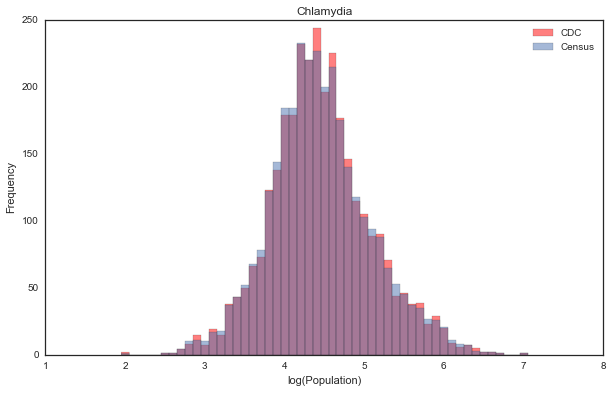

In [53]:
fig = plt.figure(figsize=(10, 6))
data = np.log10(df_completely_clean['Population'])
binwidth = 0.1
bins=np.arange(min(data), max(data) + binwidth, binwidth)

ax = data.plot.hist(bins=bins, alpha=0.5, label='CDC', color='red')
ax.set_xlabel("log(Population)")
ax.set_title("Chlamydia")

data2 = np.log10(df_census_clean["hd01s001"])
ax2 = data2.plot.hist(bins=bins, alpha=0.5, label='Census')

plt.legend()
plt.savefig('../graphics/county_population_comparison.png', bbox_inches='tight', dpi=150)

In [54]:
data = np.log10(df_completely_clean['Population'])
data2 = np.log10(df_census_clean["hd01s001"])
len(data), len(data2)

(3143, 3143)

The CDC and Census data have the same number of entries. But are the FIPS and geoid2 exactly the same?

In [55]:
true = df_completely_clean["FIPS"].isin(df_census_clean["geoid2"])
true.head()#.sort_values()

0    True
1    True
2    True
3    True
4    True
Name: FIPS, dtype: bool

In [56]:
not_in_census = set(df_completely_clean["FIPS"])-set(df_census_clean["geoid2"])
len(not_in_census)

83

No, 83 are not in common. We will have to make sure to exclude those later on.

We don't need all of the columns in the Census data. Let's select a subset of the data for modeling:

In [57]:
df_census_subset = df_census_clean[["geoid2",
                                    "hd01s001",  #log10(population)
                                    "hd02s002",  #under 5 yrs
                                    "hd02s003",  #5-9 yrs 
                                    "hd02s004",  #10-14
                                    "hd02s005",  #15-19
                                    "hd02s006",  #20-24
                                    "hd02s007",  #25-29
                                    "hd02s008",  #30-34
                                    "hd02s009",  #35-39
                                    "hd02s010",  #40-44
                                    "hd02s011",  #45-49
                                    "hd02s012",  #50-54
                                    "hd02s013",  #55-59
                                    "hd02s014",  #60-64
                                    "hd02s015",  #65-69
                                    "hd02s016",  #70-74
                                    "hd02s017",  #75-79
                                    "hd02s018",  #80-84
                                    "hd02s019",  #85 and over
                                    "hd01s020",  #median age
                                    "hd02s026",  #male percent
                                    "hd02s051",  #female percent
                                    "hd02s078",  #white
                                    "hd02s079",  #black
                                    "hd02s080",  #native
                                    "hd02s081",  #asian
                                    "hd02s089",  #pacific
                                    "hd02s095",  #two or more
                                    "hd02s107",  #hispanic
                                    "hd02s131",  #in households
                                    "hd02s132",  #householder
                                    "hd02s133",  #spouse
                                    "hd02s134",  #child
                                    "hd02s135",  #child w own child under 18
                                    "hd02s136",  #other relatives
                                    "hd02s143",  #in group quarters
                                    "hd02s151",  #family households
                                    "hd02s152",  #family households w own child under 18
                                    "hd02s153",  #husband-wife family
                                    "hd02s154",  #husband-wife family w own child under 18
                                    "hd02s159",  #nonfamily households
                                    "hd01s167",  #average household size
                                    "hd01s168",  #average family size
                                    "hd02s181",  #owner occupied housing units
                                    "hd02s184"   #renter occupied housing units
                                   ]].copy()
df_census_subset.head()

,geoid2,hd01s001,hd02s002,hd02s003,hd02s004,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s012,hd02s013,hd02s014,hd02s015,hd02s016,hd02s017,hd02s018,hd02s019,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184
0,1001,54571,6.6,7.3,7.9,7.9,5.6,5.8,6.1,7.6,7.5,7.9,7.1,5.6,5.1,4.2,3.2,2.3,1.3,1.0,37.0,48.7,51.3,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,0.8,74.5,34.9,56.2,25.3,25.5,2.68,3.13,75.4,24.6
1,1003,182265,6.1,6.4,6.5,6.4,5.2,5.6,5.9,6.3,6.6,7.4,7.4,6.9,6.6,5.6,4.2,3.1,2.2,1.8,41.1,48.9,51.1,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,1.3,69.9,28.0,54.5,19.9,30.1,2.46,2.93,72.5,27.5
2,1005,27457,6.2,6.0,5.8,6.3,6.5,7.3,6.6,6.6,6.6,7.7,7.0,6.6,6.6,4.7,3.5,2.5,2.0,1.6,39.0,53.1,46.9,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,11.6,68.4,27.4,43.7,14.4,31.6,2.47,3.01,66.8,33.2
3,1007,22915,6.0,6.1,6.3,6.7,6.5,7.0,7.2,7.6,7.1,7.9,6.9,6.1,5.8,4.2,3.3,2.4,1.5,1.2,37.8,53.7,46.3,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,9.7,72.3,29.5,52.5,20.1,27.7,2.60,3.09,75.6,24.4
4,1009,57322,6.3,6.8,7.1,7.0,5.4,6.0,6.0,6.8,7.0,7.3,6.8,6.4,6.2,5.0,3.8,2.6,1.8,1.4,39.0,49.5,50.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,0.9,75.0,31.1,60.6,24.1,25.0,2.63,3.07,80.6,19.4


The population variable is the feature with the larges range. We can engineer a new feature to be the log of the population number. Maybe there is just a weak dependence on population and the log will pick this up better than the actual number.

In [58]:
df_census_subset['hd01s001'] = df_census_subset['hd01s001'].apply(np.log10) 

In [59]:
df_census_subset['hd02s002'] = df_census_subset['hd02s002']+df_census_subset['hd02s003']+df_census_subset['hd02s004'] 
df_census_subset['hd02s011'] = df_census_subset['hd02s011']+df_census_subset['hd02s012'] 
df_census_subset['hd02s013'] = df_census_subset['hd02s013']+df_census_subset['hd02s014'] 
df_census_subset['hd02s015'] = df_census_subset['hd02s015']+df_census_subset['hd02s016']+df_census_subset['hd02s017']+df_census_subset['hd02s018']+df_census_subset['hd02s019'] 

In [60]:
df_census_combined_subset = df_census_subset[["geoid2",
                                    "hd01s001",  #log10(population)
                                    "hd02s002",  #0-14
                                    "hd02s005",  #15-19
                                    "hd02s006",  #20-24
                                    "hd02s007",  #25-29
                                    "hd02s008",  #30-34
                                    "hd02s009",  #35-39
                                    "hd02s010",  #40-44
                                    "hd02s011",  #45-54
                                    "hd02s013",  #55-64
                                    "hd02s015",  #65+
                                    "hd01s020",  #median age
                                    "hd02s026",  #male percent
                                    "hd02s051",  #female percent
                                    "hd02s078",  #white
                                    "hd02s079",  #black
                                    "hd02s080",  #native
                                    "hd02s081",  #asian
                                    "hd02s089",  #pacific
                                    "hd02s095",  #two or more
                                    "hd02s107",  #hispanic
                                    "hd02s131",  #in households
                                    "hd02s132",  #householder
                                    "hd02s133",  #spouse
                                    "hd02s134",  #child
                                    "hd02s135",  #child w own child under 18
                                    "hd02s136",  #other relatives
                                    "hd02s143",  #in group quarters
                                    "hd02s151",  #family households
                                    "hd02s152",  #family households w own child under 18
                                    "hd02s153",  #husband-wife family
                                    "hd02s154",  #husband-wife family w own child under 18
                                    "hd02s159",  #nonfamily households
                                    "hd01s167",  #average household size
                                    "hd01s168",  #average family size
                                    "hd02s181",  #owner occupied housing units
                                    "hd02s184"   #renter occupied housing units
                                   ]].copy()
df_census_combined_subset.head()

,geoid2,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184
0,1001,4.736962,21.8,7.9,5.6,5.8,6.1,7.6,7.5,15.0,10.7,12.0,37.0,48.7,51.3,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,0.8,74.5,34.9,56.2,25.3,25.5,2.68,3.13,75.4,24.6
1,1003,5.260703,19.0,6.4,5.2,5.6,5.9,6.3,6.6,14.8,13.5,16.9,41.1,48.9,51.1,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,1.3,69.9,28.0,54.5,19.9,30.1,2.46,2.93,72.5,27.5
2,1005,4.438653,18.0,6.3,6.5,7.3,6.6,6.6,6.6,14.7,13.2,14.3,39.0,53.1,46.9,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,11.6,68.4,27.4,43.7,14.4,31.6,2.47,3.01,66.8,33.2
3,1007,4.360120,18.4,6.7,6.5,7.0,7.2,7.6,7.1,14.8,11.9,12.6,37.8,53.7,46.3,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,9.7,72.3,29.5,52.5,20.1,27.7,2.60,3.09,75.6,24.4
4,1009,4.758321,20.2,7.0,5.4,6.0,6.0,6.8,7.0,14.1,12.6,14.6,39.0,49.5,50.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,0.9,75.0,31.1,60.6,24.1,25.0,2.63,3.07,80.6,19.4


In [61]:
df_cdc = df_completely_clean[true].copy()
df_cdc_subset = df_cdc[["FIPS","Population","Cases"]]
df_cdc_subset.shape

(3060, 3)

In [62]:
df_cdc_subset.head()

,FIPS,Population,Cases
0,1001,55246,220
1,1003,195540,667
2,1005,27076,166
3,1007,22512,100
4,1009,57872,72


In [63]:
true_new = df_cdc_subset["FIPS"].isin(df_census_clean["geoid2"])
true_new.describe()

count    3060
mean        1
std         0
min      True
25%         1
50%         1
75%         1
max      True
Name: FIPS, dtype: object

### Add income data

In [64]:
df_census_acs = pd.read_csv("../data/census/ACS_14_5YR_income.csv", header=0, skiprows={1})
df_census_acs_labels = pd.read_csv("../data/census/ACS_14_5YR_income_metadata.csv", header=0, nrows=1)

In [65]:
columnnames = list(df_census_acs.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census_acs.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)
    df_census_acs_labels.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

geoid
geoid2
geodisplaylabel
hd01vd01
hd02vd01


In [66]:
df_census_acs_clean = df_census_acs.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_acs_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid              object
geoid2              int64
geodisplaylabel    object
hd01vd01            int64
hd02vd01            int64
dtype: object

In [67]:
df_census_acs_clean.head()

,geoid,geoid2,geodisplaylabel,hd01vd01,hd02vd01
0,0500000US01001,1001,"Autauga County, Alabama",52475,2760
1,0500000US01003,1003,"Baldwin County, Alabama",50183,1378
2,0500000US01005,1005,"Barbour County, Alabama",35634,2440
3,0500000US01007,1007,"Bibb County, Alabama",37984,3295
4,0500000US01009,1009,"Blount County, Alabama",44409,2225


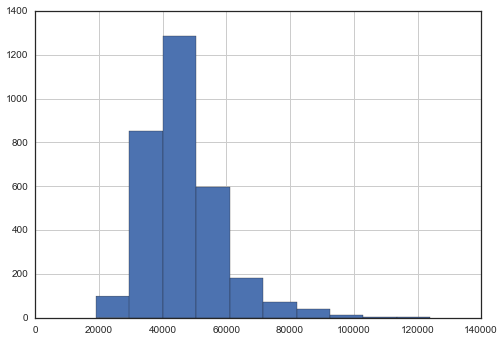

In [68]:
df_census_acs_clean["hd01vd01"].hist()

In [69]:
df_census_acs_labels

,geoid,Id
0,GEO.id2,Id2


In [70]:
true = df_completely_clean["FIPS"].isin(df_census_acs_clean["geoid2"])

In [71]:
not_in_census = set(df_completely_clean["FIPS"])-set(df_census_acs_clean["geoid2"])
len(not_in_census)

83

In [72]:
df_census_acs_clean.head()

,geoid,geoid2,geodisplaylabel,hd01vd01,hd02vd01
0,0500000US01001,1001,"Autauga County, Alabama",52475,2760
1,0500000US01003,1003,"Baldwin County, Alabama",50183,1378
2,0500000US01005,1005,"Barbour County, Alabama",35634,2440
3,0500000US01007,1007,"Bibb County, Alabama",37984,3295
4,0500000US01009,1009,"Blount County, Alabama",44409,2225


In [73]:
df_census_acs_subset = df_census_acs_clean[["geoid2",
                                    "hd01vd01"  #median income
                                   ]].copy()
df_census_acs_subset.head()

,geoid2,hd01vd01
0,1001,52475
1,1003,50183
2,1005,35634
3,1007,37984
4,1009,44409


### Add LGBT data

In [74]:
df_census_lgbt = pd.read_csv("../data/census/DEC_10_lgbt.csv", header=0, skiprows={1})
df_census_lgbt_labels = pd.read_csv("../data/census/DEC_10_lgbt_metadata.csv", header=0, nrows=1)

In [75]:
columnnames = list(df_census_lgbt.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census_lgbt.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)
    df_census_lgbt_labels.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

geoid
geoid2
geodisplaylabel
d001
d002
d003
d004
d005
d006
d007
d008
d009
d010
d011
d012
d013
d014
d015
d016
d017
d018
d019
d020
d021
d022
d023
d024
d025
d026
d027
d028
d029
d030
d031
d032
d033
d034


In [76]:
df_census_lgbt_clean = df_census_lgbt.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_lgbt_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid              object
geoid2              int64
geodisplaylabel    object
d001                int64
d002                int64
d003                int64
d004                int64
d005                int64
d006                int64
d007                int64
d008                int64
d009                int64
d010                int64
d011                int64
d012                int64
d013                int64
d014                int64
d015                int64
d016                int64
d017                int64
d018                int64
d019                int64
d020                int64
d021                int64
d022                int64
d023                int64
d024                int64
d025                int64
d026                int64
d027                int64
d028                int64
d029                int64
d030                int64
d031                int64
d032                int64
d033                int64
d034                int64
dtype: object

In [77]:
df_census_lgbt_clean.head()

,geoid,geoid2,geodisplaylabel,d001,d002,d003,d004,d005,d006,d007,d008,d009,d010,d011,d012,d013,d014,d015,d016,d017,d018,d019,d020,d021,d022,d023,d024,d025,d026,d027,d028,d029,d030,d031,d032,d033,d034
0,0500000US01001,1001,"Autauga County, Alabama",20221,11367,9813,4667,4321,346,5146,1554,855,789,66,699,882,61,13,12,1,48,405,165,156,9,240,58,18,18,0,40,358,184,171,13,174,7972
1,0500000US01003,1003,"Baldwin County, Alabama",73180,39913,33054,12586,11591,995,20468,6859,3192,2968,224,3667,3686,201,49,46,3,152,1748,597,561,36,1151,252,66,61,5,186,1485,663,640,23,822,29581
2,0500000US01005,1005,"Barbour County, Alabama",9820,4293,3466,1235,1073,162,2231,827,393,341,52,434,467,23,8,7,1,15,190,90,82,8,100,36,18,15,3,18,218,131,114,17,87,5060
3,0500000US01007,1007,"Bibb County, Alabama",7953,4172,3522,1455,1298,157,2067,650,334,301,33,316,354,15,9,8,1,6,161,55,51,4,106,16,7,6,1,9,162,94,88,6,68,3427
4,0500000US01009,1009,"Blount County, Alabama",21578,13077,11278,4800,4317,483,6478,1799,971,891,80,828,800,42,16,14,2,26,388,156,146,10,232,80,22,20,2,58,290,163,153,10,127,7701


In [78]:
true = df_completely_clean["FIPS"].isin(df_census_lgbt_clean["geoid2"])

In [79]:
not_in_census = set(df_completely_clean["FIPS"])-set(df_census_lgbt_clean["geoid2"])
len(not_in_census)

83

In [80]:
df_census_lgbt_subset = df_census_lgbt_clean[["geoid2",
                                    "d001",  #Total households
                                    "d002",  #Husband-wife households
                                    "d014",  #Unmarried-partner households: - Male householder and male partner
                                    "d019",  #Unmarried-partner households: - Male householder and female partner
                                    "d024",  #Unmarried-partner households: - Female householder and female partner
                                    "d029"   #Unmarried-partner households: - Female householder and male partner
                                   ]].copy()
df_census_lgbt_subset.head()

,geoid2,d001,d002,d014,d019,d024,d029
0,1001,20221,11367,61,405,58,358
1,1003,73180,39913,201,1748,252,1485
2,1005,9820,4293,23,190,36,218
3,1007,7953,4172,15,161,16,162
4,1009,21578,13077,42,388,80,290


In [81]:
df_census_lgbt_subset.describe()

,geoid2,d001,d002,d014,d019,d024,d029
count,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,30390.411709,37135.314031,17979.757238,135.309895,1136.566656,151.676106,1040.561565
std,15164.717720,111974.893658,51305.844438,599.157691,3529.334381,504.522984,3227.563877
min,1001.000000,39.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,18178.000000,4367.500000,2293.000000,9.000000,127.000000,12.000000,100.000000
50%,29177.000000,10014.000000,5192.000000,23.000000,303.000000,31.000000,246.000000
75%,45082.000000,25818.000000,13139.000000,66.000000,824.000000,91.000000,710.500000
max,56045.000000,3241204.000000,1480665.000000,18185.000000,110488.000000,14519.000000,90407.000000


In [82]:
df_census_lgbt_subset["d002"] = df_census_lgbt_subset["d002"]/df_census_lgbt_subset["d001"]
df_census_lgbt_subset["d014"] = df_census_lgbt_subset["d014"]/df_census_lgbt_subset["d001"]
df_census_lgbt_subset["d019"] = df_census_lgbt_subset["d019"]/df_census_lgbt_subset["d001"]
df_census_lgbt_subset["d024"] = df_census_lgbt_subset["d024"]/df_census_lgbt_subset["d001"]
df_census_lgbt_subset["d029"] = df_census_lgbt_subset["d029"]/df_census_lgbt_subset["d001"]

In [83]:
df_census_lgbt_subset.describe()

,geoid2,d001,d002,d014,d019,d024,d029
count,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,30390.411709,37135.314031,0.516816,0.002506,0.030704,0.003232,0.024897
std,15164.717720,111974.893658,0.064012,0.001299,0.007911,0.001300,0.007931
min,1001.000000,39.000000,0.115942,0.000000,0.000000,0.000000,0.000000
25%,18178.000000,4367.500000,0.484253,0.001803,0.025409,0.002473,0.020098
50%,29177.000000,10014.000000,0.523133,0.002375,0.030214,0.003172,0.024544
75%,45082.000000,25818.000000,0.556148,0.003008,0.035367,0.003855,0.029104
max,56045.000000,3241204.000000,0.792199,0.022064,0.083668,0.017631,0.100173


In [84]:
df_census_lgbt_subset.drop('d001', axis=1, inplace=True)

## Add area data to calculate density

In [85]:
df_census_area = pd.read_csv("../data/census/Area_counties.csv", header=0, skiprows={1}, usecols={"STCOU", "LND110210D"})

In [86]:
df_census_area.head()

,STCOU,LND110210D
0,1001,594.44
1,1003,1589.78
2,1005,884.88
3,1007,622.58
4,1009,644.78


In [87]:
columnnames = list(df_census_area.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census_area.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

stcou
lnd110210d


In [88]:
df_census_area_clean = df_census_area.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_area_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


stcou           int64
lnd110210d    float64
dtype: object

In [89]:
true = df_completely_clean["FIPS"].isin(df_census_area_clean["stcou"])

In [90]:
not_in_census = set(df_completely_clean["FIPS"])-set(df_census_area_clean["stcou"])
len(not_in_census)

83

In [91]:
df_census_area_clean.describe()

,stcou,lnd110210d
count,3196.000000,3196.000000
mean,30390.024093,2194.357672
std,15169.791703,14123.580733
min,1001.000000,0.000000
25%,18176.500000,431.782500
50%,29180.000000,622.635000
75%,45079.500000,943.930000
max,56045.000000,570640.950000


## Merge the data sets into one data frame

In [92]:
df_merged = pd.merge(df_cdc_subset, df_census_combined_subset, left_on='FIPS', right_on='geoid2', how='inner', sort=False)

In [93]:
df_merged2 = pd.merge(df_merged, df_census_acs_subset, left_on='FIPS', right_on='geoid2', how='inner', sort=False)

In [94]:
df_merged = pd.merge(df_merged2, df_census_lgbt_subset, left_on='FIPS', right_on='geoid2', how='inner', sort=False)

In [95]:
df_merged2 = pd.merge(df_merged, df_census_area_clean, left_on='FIPS', right_on='stcou', how='inner', sort=False)

In [96]:
df_merged = df_merged2

In [97]:
df_merged.head()

,FIPS,Population,Cases,geoid2_x,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,geoid2_y,hd01vd01,geoid2,d002,d014,d019,d024,d029,stcou,lnd110210d
0,1001,55246,220,1001,4.736962,21.8,7.9,5.6,5.8,6.1,7.6,7.5,15.0,10.7,12.0,37.0,48.7,51.3,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,0.8,74.5,34.9,56.2,25.3,25.5,2.68,3.13,75.4,24.6,1001,52475,1001,0.562138,0.003017,0.020029,0.002868,0.017704,1001,594.44
1,1003,195540,667,1003,5.260703,19.0,6.4,5.2,5.6,5.9,6.3,6.6,14.8,13.5,16.9,41.1,48.9,51.1,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,1.3,69.9,28.0,54.5,19.9,30.1,2.46,2.93,72.5,27.5,1003,50183,1003,0.545409,0.002747,0.023886,0.003444,0.020292,1003,1589.78
2,1005,27076,166,1005,4.438653,18.0,6.3,6.5,7.3,6.6,6.6,6.6,14.7,13.2,14.3,39.0,53.1,46.9,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,11.6,68.4,27.4,43.7,14.4,31.6,2.47,3.01,66.8,33.2,1005,35634,1005,0.437169,0.002342,0.019348,0.003666,0.022200,1005,884.88
3,1007,22512,100,1007,4.360120,18.4,6.7,6.5,7.0,7.2,7.6,7.1,14.8,11.9,12.6,37.8,53.7,46.3,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,9.7,72.3,29.5,52.5,20.1,27.7,2.60,3.09,75.6,24.4,1007,37984,1007,0.524582,0.001886,0.020244,0.002012,0.020370,1007,622.58
4,1009,57872,72,1009,4.758321,20.2,7.0,5.4,6.0,6.0,6.8,7.0,14.1,12.6,14.6,39.0,49.5,50.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,0.9,75.0,31.1,60.6,24.1,25.0,2.63,3.07,80.6,19.4,1009,44409,1009,0.606034,0.001946,0.017981,0.003707,0.013440,1009,644.78


In [98]:
df_merged.drop('stcou', axis=1, inplace=True)
df_merged.drop('geoid2_x', axis=1, inplace=True)
df_merged.drop('geoid2', axis=1, inplace=True)
df_merged.drop('geoid2_y', axis=1, inplace=True)

In [99]:
df_merged["lnd110210d"] = df_merged["Population"]/(df_merged["lnd110210d"]+1.0)

In [100]:
df_merged.head()

,FIPS,Population,Cases,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,hd01vd01,d002,d014,d019,d024,d029,lnd110210d
0,1001,55246,220,4.736962,21.8,7.9,5.6,5.8,6.1,7.6,7.5,15.0,10.7,12.0,37.0,48.7,51.3,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,0.8,74.5,34.9,56.2,25.3,25.5,2.68,3.13,75.4,24.6,52475,0.562138,0.003017,0.020029,0.002868,0.017704,92.781808
1,1003,195540,667,5.260703,19.0,6.4,5.2,5.6,5.9,6.3,6.6,14.8,13.5,16.9,41.1,48.9,51.1,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,1.3,69.9,28.0,54.5,19.9,30.1,2.46,2.93,72.5,27.5,50183,0.545409,0.002747,0.023886,0.003444,0.020292,122.920831
2,1005,27076,166,4.438653,18.0,6.3,6.5,7.3,6.6,6.6,6.6,14.7,13.2,14.3,39.0,53.1,46.9,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,11.6,68.4,27.4,43.7,14.4,31.6,2.47,3.01,66.8,33.2,35634,0.437169,0.002342,0.019348,0.003666,0.022200,30.563959
3,1007,22512,100,4.360120,18.4,6.7,6.5,7.0,7.2,7.6,7.1,14.8,11.9,12.6,37.8,53.7,46.3,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,9.7,72.3,29.5,52.5,20.1,27.7,2.60,3.09,75.6,24.4,37984,0.524582,0.001886,0.020244,0.002012,0.020370,36.101222
4,1009,57872,72,4.758321,20.2,7.0,5.4,6.0,6.0,6.8,7.0,14.1,12.6,14.6,39.0,49.5,50.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,0.9,75.0,31.1,60.6,24.1,25.0,2.63,3.07,80.6,19.4,44409,0.606034,0.001946,0.017981,0.003707,0.013440,89.615659


In [101]:
df_merged.shape

(3060, 47)

<Container object of 47 artists>

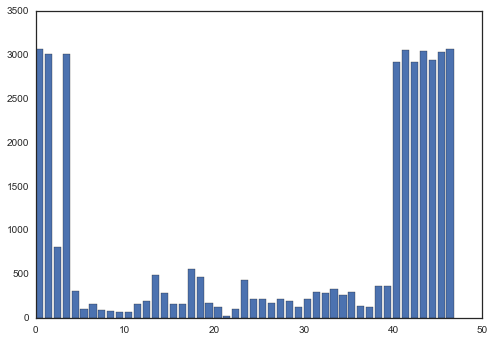

In [102]:
unique_values = [len(np.unique(df_merged.values[:,i])) for i in range(df_merged.values.shape[1])] 
plt.bar(range(df_merged.values.shape[1]), unique_values)

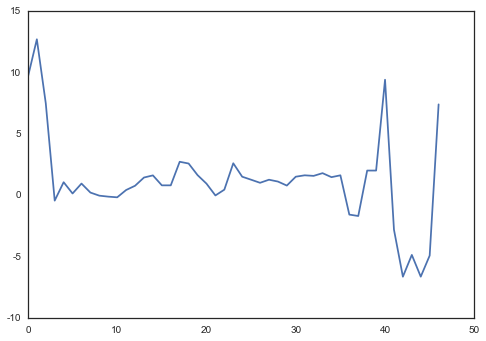

In [103]:
plt.plot(np.log(np.std(df_merged.values, axis=0)))

In [104]:
df_merged.to_csv("../data/chlamydia_cdc_census.csv", index=False)

In [105]:
df_merged.shape

(3060, 47)

## Model the Chlamydia rate

In [106]:
df_merged = pd.read_csv("../data/chlamydia_cdc_census.csv")

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


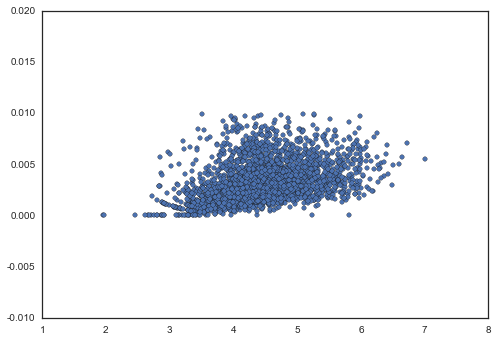

In [107]:
plt.scatter(np.log10(df_merged["Population"]), df_merged["Cases"]/df_merged["Population"])

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


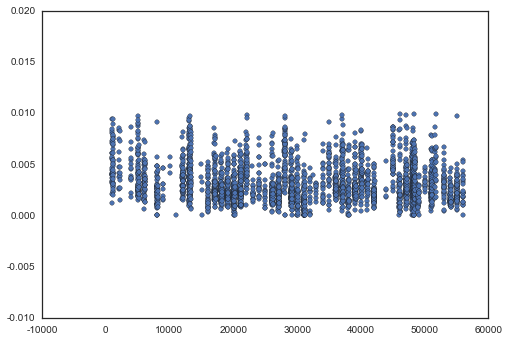

In [108]:
plt.scatter(df_merged["FIPS"], df_merged["Cases"]/df_merged["Population"])

### Plot the correlation matrix

In [109]:
df_all = df_merged.copy()
df_all["Rate"] = df_all["Cases"]/df_all["Population"]
corr = df_all.corr()

In [110]:
pearsonr = corr["Rate"]
pearsonr

FIPS         -0.096268
Population    0.180889
Cases         0.245175
hd01s001      0.360188
hd02s002      0.190625
hd02s005      0.304432
hd02s006      0.395677
hd02s007      0.459995
hd02s008      0.325028
hd02s009      0.178515
hd02s010      0.016332
hd02s011     -0.351527
hd02s013     -0.371801
hd02s015     -0.387918
hd01s020     -0.469234
hd02s026     -0.150985
hd02s051      0.150985
hd02s078     -0.702417
hd02s079      0.629293
hd02s080      0.184687
hd02s081      0.143452
hd02s089     -0.007155
hd02s095      0.214384
hd02s107      0.154928
hd02s131     -0.123808
hd02s132     -0.271132
hd02s133     -0.687693
hd02s134      0.175148
hd02s135     -0.021083
hd02s136      0.575035
hd02s143      0.123800
hd02s151     -0.084822
hd02s152      0.168630
hd02s153     -0.603637
hd02s154     -0.180042
hd02s159      0.084810
hd01s167      0.217388
hd01s168      0.328821
hd02s181     -0.492802
hd02s184      0.492803
hd01vd01     -0.173462
d002         -0.603659
d014          0.149278
d019       

In [111]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


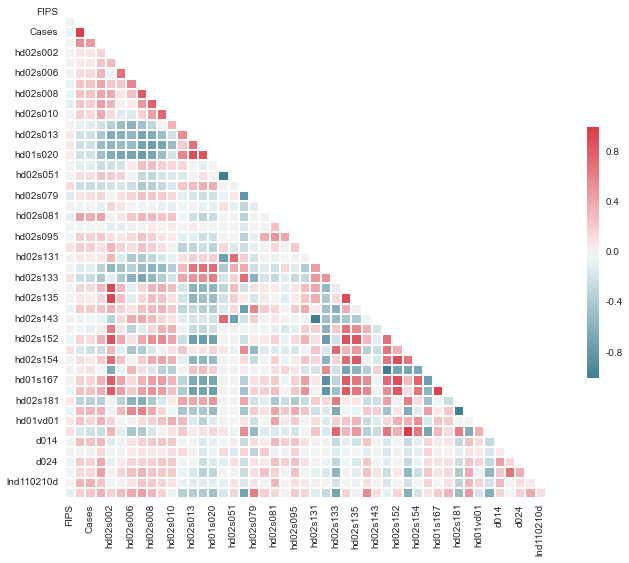

In [112]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.savefig('../graphics/cross-correlation.png', bbox_inches='tight', dpi=150)

In [113]:
#sns.pairplot(df_all, size=2.5)
#plt.savefig('../graphics/pairplot_chlamydia.png', bbox_inches='tight', dpi=150)

### Make principal component analysis

In [114]:
from sklearn.decomposition import PCA

In [115]:
df_merged.describe()

,FIPS,Population,Cases,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,hd01vd01,d002,d014,d019,d024,d029,lnd110210d
count,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000
mean,30492.802614,100423.684967,433.365033,4.460522,19.163007,6.908072,5.977222,5.819314,5.695294,5.899739,6.297484,15.002190,13.250327,15.985556,40.491667,50.003856,49.996144,84.076340,8.121307,1.550719,1.165033,0.082418,1.966765,8.417353,96.604379,39.254118,20.403791,27.047647,20.409281,5.134248,3.395654,67.828627,27.814542,52.057712,19.173268,32.171438,2.476042,2.988451,72.576307,27.423791,46800.265359,0.520577,0.002492,0.030613,0.003221,0.024522,239.640924
std,15071.256920,323873.098080,1758.821272,0.634640,2.846254,1.135197,2.546279,1.223101,0.950620,0.878120,0.830619,1.506377,2.129781,4.166765,4.959052,2.204346,2.204346,15.045667,13.038226,5.071524,2.533382,0.967483,1.549707,13.303866,4.451890,3.484761,2.711350,3.484574,3.001770,2.163983,4.451875,4.990887,4.766401,5.948292,4.289568,4.990872,0.203247,0.181387,7.350396,7.350283,12025.134705,0.059487,0.001291,0.007625,0.001295,0.007228,1610.657866
min,1001.000000,90.000000,0.000000,1.913814,0.000000,0.000000,1.300000,2.300000,2.400000,1.200000,2.800000,6.300000,4.000000,3.500000,22.600000,43.200000,27.900000,14.200000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,45.000000,17.600000,7.500000,4.400000,0.000000,0.700000,0.000000,18.800000,0.000000,11.600000,0.000000,13.400000,1.260000,2.000000,1.400000,10.200000,19146.000000,0.115942,0.000000,0.000000,0.000000,0.000000,0.069674
25%,19006.500000,11208.000000,26.000000,4.051722,17.400000,6.300000,4.700000,5.100000,5.100000,5.400000,5.800000,14.200000,12.000000,13.300000,37.700000,48.900000,49.600000,76.575000,0.500000,0.200000,0.300000,0.000000,1.100000,1.600000,96.300000,37.400000,18.800000,25.000000,18.600000,3.500000,1.100000,65.200000,25.000000,48.800000,16.500000,29.300000,2.350000,2.880000,69.200000,22.600000,38810.000000,0.488003,0.001797,0.025435,0.002469,0.020005,17.078483
50%,29188.000000,25987.000000,78.000000,4.414815,19.100000,6.800000,5.500000,5.600000,5.600000,5.900000,6.300000,15.100000,13.100000,15.700000,40.500000,49.500000,50.500000,89.450000,1.900000,0.400000,0.500000,0.000000,1.600000,3.300000,98.200000,39.500000,20.700000,27.100000,20.400000,4.900000,1.800000,68.100000,27.450000,52.500000,18.700000,31.900000,2.450000,2.970000,73.800000,26.200000,45009.500000,0.524803,0.002367,0.030222,0.003160,0.024365,45.094109
75%,45085.500000,67582.250000,241.250000,4.825413,20.700000,7.300000,6.500000,6.400000,6.200000,6.400000,6.800000,15.800000,14.300000,18.300000,43.400000,50.400000,51.100000,95.625000,9.400000,0.800000,1.000000,0.100000,2.300000,8.400000,98.900000,41.300000,22.225000,29.000000,22.000000,6.500000,3.700000,70.700000,30.100000,55.700000,21.000000,34.800000,2.570000,3.070000,77.400000,30.800000,52013.500000,0.556712,0.002993,0.035313,0.003841,0.028793,114.277352
max,56045.000000,10017068.000000,54881.000000,6.992050,33.600000,18.300000,28.100000,16.100000,11.700000,9.700000,11.900000,24.500000,28.100000,43.400000,62.700000,72.100000,56.800000,99.200000,84.400000,75.500000,43.900000,48.900000,29.500000,95.700000,100.000000,76.700000,28.800000,

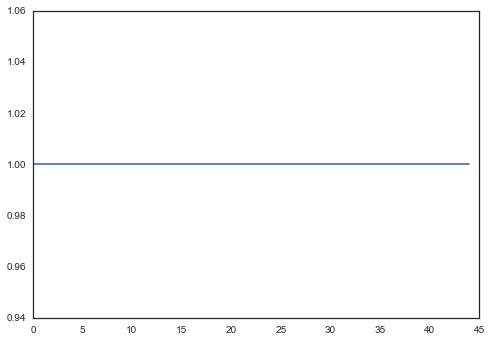

In [116]:
df_new = df_merged.drop(["FIPS","Cases"], axis=1)
X = df_new.values

columns = X.shape[1]
for column in np.arange(columns):
    mean_temp = X[:,column].mean()
    std_temp = X[:,column].std()
    X[:,column] = (X[:,column]-mean_temp)/std_temp

plt.plot((np.std(X, axis=0)))

In [117]:
X.shape

(3060, 45)

In [118]:
pca = PCA(n_components=44)
pca.fit(X)
pca.explained_variance_ratio_

array([  2.69921884e-01,   1.90278664e-01,   9.30640065e-02,
         7.23782712e-02,   6.24436753e-02,   4.43868669e-02,
         4.16750844e-02,   2.91740925e-02,   2.70615975e-02,
         2.38013945e-02,   1.88585307e-02,   1.56524336e-02,
         1.48047143e-02,   1.23828589e-02,   1.14220041e-02,
         1.08218100e-02,   8.82899796e-03,   8.64470165e-03,
         7.58203540e-03,   6.80307559e-03,   5.01282172e-03,
         4.46509181e-03,   3.82090648e-03,   3.18207349e-03,
         2.96301074e-03,   2.57147980e-03,   1.96469833e-03,
         1.58935929e-03,   1.41475569e-03,   1.06042952e-03,
         8.57599305e-04,   2.85849664e-04,   2.19045573e-04,
         1.62230637e-04,   1.61542561e-04,   1.38356709e-04,
         7.17766666e-05,   5.10631308e-05,   1.33234967e-05,
         7.61768564e-06,   2.61942672e-07,   2.88391824e-09,
         1.99653563e-09,   1.82103246e-09])

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


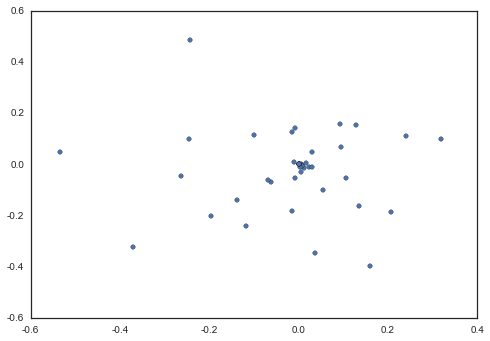

In [119]:
plt.scatter(pca.components_[:,0], pca.components_[:,1])

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


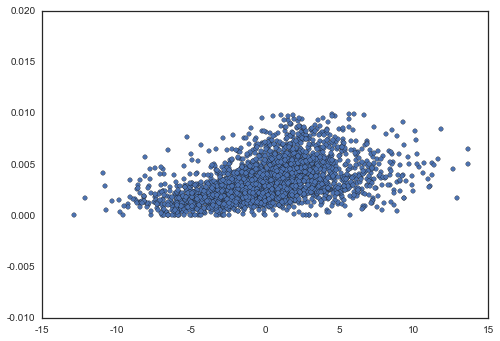

In [120]:
X_trans = pca.transform(X)
Y = df_merged["Cases"]/df_merged["Population"]
plt.scatter(X_trans[:,0],Y)

### Linear regression

In [121]:
from sklearn import linear_model

In [122]:
df_merged = pd.read_csv("../data/chlamydia_cdc_census.csv")

In [123]:
df_new = df_merged.drop(["FIPS","Cases", "d002", "hd02s051", "hd02s143", "hd02s159", "hd02s184", "hd01s001"], axis=1)

In [124]:
df_new.head()

,Population,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s151,hd02s152,hd02s153,hd02s154,hd01s167,hd01s168,hd02s181,hd01vd01,d014,d019,d024,d029,lnd110210d
0,55246,21.8,7.9,5.6,5.8,6.1,7.6,7.5,15.0,10.7,12.0,37.0,48.7,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,74.5,34.9,56.2,25.3,2.68,3.13,75.4,52475,0.003017,0.020029,0.002868,0.017704,92.781808
1,195540,19.0,6.4,5.2,5.6,5.9,6.3,6.6,14.8,13.5,16.9,41.1,48.9,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,69.9,28.0,54.5,19.9,2.46,2.93,72.5,50183,0.002747,0.023886,0.003444,0.020292,122.920831
2,27076,18.0,6.3,6.5,7.3,6.6,6.6,6.6,14.7,13.2,14.3,39.0,53.1,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,68.4,27.4,43.7,14.4,2.47,3.01,66.8,35634,0.002342,0.019348,0.003666,0.022200,30.563959
3,22512,18.4,6.7,6.5,7.0,7.2,7.6,7.1,14.8,11.9,12.6,37.8,53.7,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,72.3,29.5,52.5,20.1,2.60,3.09,75.6,37984,0.001886,0.020244,0.002012,0.020370,36.101222
4,57872,20.2,7.0,5.4,6.0,6.0,6.8,7.0,14.1,12.6,14.6,39.0,49.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,75.0,31.1,60.6,24.1,2.63,3.07,80.6,44409,0.001946,0.017981,0.003707,0.013440,89.615659


In [125]:
df_merged.describe()

,FIPS,Population,Cases,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,hd01vd01,d002,d014,d019,d024,d029,lnd110210d
count,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000
mean,30492.802614,100423.684967,433.365033,4.460522,19.163007,6.908072,5.977222,5.819314,5.695294,5.899739,6.297484,15.002190,13.250327,15.985556,40.491667,50.003856,49.996144,84.076340,8.121307,1.550719,1.165033,0.082418,1.966765,8.417353,96.604379,39.254118,20.403791,27.047647,20.409281,5.134248,3.395654,67.828627,27.814542,52.057712,19.173268,32.171438,2.476042,2.988451,72.576307,27.423791,46800.265359,0.520577,0.002492,0.030613,0.003221,0.024522,239.640924
std,15071.256920,323873.098080,1758.821272,0.634640,2.846254,1.135197,2.546279,1.223101,0.950620,0.878120,0.830619,1.506377,2.129781,4.166765,4.959052,2.204346,2.204346,15.045667,13.038226,5.071524,2.533382,0.967483,1.549707,13.303866,4.451890,3.484761,2.711350,3.484574,3.001770,2.163983,4.451875,4.990887,4.766401,5.948292,4.289568,4.990872,0.203247,0.181387,7.350396,7.350283,12025.134705,0.059487,0.001291,0.007625,0.001295,0.007228,1610.657866
min,1001.000000,90.000000,0.000000,1.913814,0.000000,0.000000,1.300000,2.300000,2.400000,1.200000,2.800000,6.300000,4.000000,3.500000,22.600000,43.200000,27.900000,14.200000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,45.000000,17.600000,7.500000,4.400000,0.000000,0.700000,0.000000,18.800000,0.000000,11.600000,0.000000,13.400000,1.260000,2.000000,1.400000,10.200000,19146.000000,0.115942,0.000000,0.000000,0.000000,0.000000,0.069674
25%,19006.500000,11208.000000,26.000000,4.051722,17.400000,6.300000,4.700000,5.100000,5.100000,5.400000,5.800000,14.200000,12.000000,13.300000,37.700000,48.900000,49.600000,76.575000,0.500000,0.200000,0.300000,0.000000,1.100000,1.600000,96.300000,37.400000,18.800000,25.000000,18.600000,3.500000,1.100000,65.200000,25.000000,48.800000,16.500000,29.300000,2.350000,2.880000,69.200000,22.600000,38810.000000,0.488003,0.001797,0.025435,0.002469,0.020005,17.078483
50%,29188.000000,25987.000000,78.000000,4.414815,19.100000,6.800000,5.500000,5.600000,5.600000,5.900000,6.300000,15.100000,13.100000,15.700000,40.500000,49.500000,50.500000,89.450000,1.900000,0.400000,0.500000,0.000000,1.600000,3.300000,98.200000,39.500000,20.700000,27.100000,20.400000,4.900000,1.800000,68.100000,27.450000,52.500000,18.700000,31.900000,2.450000,2.970000,73.800000,26.200000,45009.500000,0.524803,0.002367,0.030222,0.003160,0.024365,45.094109
75%,45085.500000,67582.250000,241.250000,4.825413,20.700000,7.300000,6.500000,6.400000,6.200000,6.400000,6.800000,15.800000,14.300000,18.300000,43.400000,50.400000,51.100000,95.625000,9.400000,0.800000,1.000000,0.100000,2.300000,8.400000,98.900000,41.300000,22.225000,29.000000,22.000000,6.500000,3.700000,70.700000,30.100000,55.700000,21.000000,34.800000,2.570000,3.070000,77.400000,30.800000,52013.500000,0.556712,0.002993,0.035313,0.003841,0.028793,114.277352
max,56045.000000,10017068.000000,54881.000000,6.992050,33.600000,18.300000,28.100000,16.100000,11.700000,9.700000,11.900000,24.500000,28.100000,43.400000,62.700000,72.100000,56.800000,99.200000,84.400000,75.500000,43.900000,48.900000,29.500000,95.700000,100.000000,76.700000,28.800000,

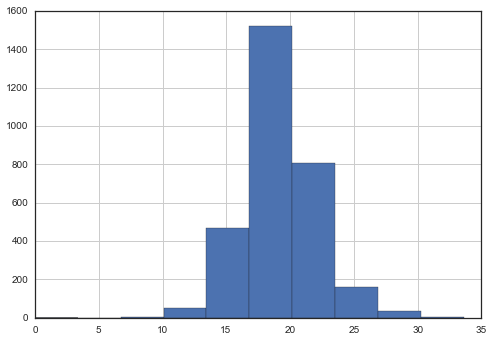

In [126]:
df_new["hd02s002"].hist()

Split data set into training/test and validation data

In [127]:
cutoff = 1

X = df_new[df_merged["Cases"]>cutoff].values
Y = df_merged[df_merged["Cases"]>cutoff].Cases/(df_merged[df_merged["Cases"]>cutoff].Population+1.0)

X_full = df_new.values
Y_full = df_merged.Cases/(df_merged.Population+1.0)

#normalize all columns to the same normalization
columns = X.shape[1]
means = np.zeros(columns)
stds = np.zeros(columns)
for column in np.arange(columns):
    mean_temp = X[:,column].mean()
    std_temp = X[:,column].std()
    means[column] = mean_temp
    stds[column] = std_temp
    X[:,column] = (X[:,column]-mean_temp)/std_temp
    X_full[:,column] = (X_full[:,column]-mean_temp)/std_temp

Ymean = Y.mean()
Ystd = Y.std()

Y = (Y-Ymean)/Ystd
Y_full = (Y_full-Ymean)/Ystd
    
ones = np.ones(round(0.75*len(X)), dtype=bool)
zeros = np.zeros(len(X)-round(0.75*len(X)), dtype=bool)
training_list = np.hstack((ones, zeros))
np.random.shuffle(training_list)
test_list = np.zeros(len(X),dtype=bool)
test_list = np.array([not i for i in training_list])

X_train = X[training_list]
X_test = X[test_list]
Y_train = Y[training_list]
Y_test = Y[test_list]

X.shape, X_train.shape, X_test.shape, Y.shape, Y_train.shape, Y_test.shape

((2975, 39), (2231, 39), (744, 39), (2975,), (2231,), (744,))

In [128]:
X.shape, Y.shape

((2975, 39), (2975,))

In [129]:
Y_test.describe()

count    744.000000
mean       0.056832
std        1.031116
min       -1.633910
25%       -0.708484
50%       -0.219195
75%        0.659171
max        3.580874
dtype: float64

In [130]:
#X_weights = df_merged.values
#X_train_weights = X_weights[training_list]
weights = 1 #X_train_weights[:,2]
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train, sample_weight=weights)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [131]:
print(regr.coef_)

[ 0.0356095  -0.06988694 -0.07594623 -0.05875577 -0.09989845 -0.03106176
 -0.10400128 -0.11232625 -0.06468976 -0.17830244 -0.23952771 -0.27577759
 -0.06844381  0.06396115  0.45580985  0.12321846  0.00421514 -0.02937032
  0.09942308  0.08865438  0.36058808  0.17235915 -0.44105933 -0.52629511
 -0.18355313 -0.20343648  0.53727007  1.00209267  0.38383007 -1.00885475
 -1.13204779  0.98718332 -0.12133679  0.11321387 -0.02861172 -0.00858582
  0.00749999  0.01800164 -0.01739585]


In [132]:
1.0-np.sum((regr.predict(X_test)-Y_test)**2)/np.sum((Y_test-np.mean(Y_test))**2)

0.72696496991456305

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


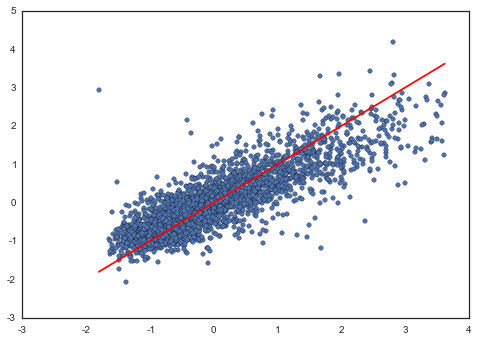

In [133]:
plt.scatter(Y,regr.predict(X))
plt.plot(np.linspace(Y.min(),Y.max(),num=10),np.linspace(Y.min(),Y.max(),num=10),color='red')

In [134]:
print('Variance score: %.5f\t(%.5f)' % (regr.score(X_test, Y_test), regr.score(X_full, Y_full)))

Variance score: 0.72696	(0.69951)


In [135]:
from sklearn import cross_validation
cv = cross_validation.ShuffleSplit(len(Y_train), n_iter=10, test_size=0.2, random_state=1)
scores_regression = cross_validation.cross_val_score(regr, X_train, Y_train, cv=cv)
scores_regression
#cross_val_score(regr, X_train, Y_train, cv=6, n_jobs=1)
#scores

array([ 0.6875356 ,  0.6204488 ,  0.67974382,  0.64380572,  0.67311258,
        0.71788804,  0.6665565 ,  0.71582916,  0.70129986,  0.63497939])

In [136]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_regression.mean(), scores_regression.std() * 2))

Accuracy: 0.67 (+/- 0.06)


In [137]:
from sklearn.metrics import explained_variance_score

In [138]:
explained_variance_score(Y_train, regr.predict(X_train))

0.70873917841384326

In [139]:
from sklearn.metrics import mean_absolute_error

In [140]:
mean_absolute_error(Y_train, regr.predict(X_train))

0.39056353396210963

In [141]:
from sklearn.metrics import mean_squared_error

In [142]:
from sklearn.metrics import median_absolute_error

In [143]:
from sklearn.metrics import r2_score

In [144]:
median_absolute_error(Y_train, regr.predict(X_train))

0.29680339624481422

In [145]:
mse_regression = mean_squared_error(Y_test, regr.predict(X_test))
r2_regression = r2_score(Y_test, regr.predict(X_test))
r2_regression, mse_regression

(0.72696496991456305, 0.28990055328030845)

Try recursive feature elimination to increase R^2

In [146]:
from sklearn.feature_selection import RFE

In [147]:
selector = RFE(regr, 20, step=1)
selector = selector.fit(X_train, Y_train)

In [148]:
selector.ranking_

array([13, 11,  9,  1,  8, 12,  6,  1, 10,  5,  7,  1,  1,  3,  1,  1, 20,
       15,  2,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       14, 18, 19, 17, 16])

In [149]:
selector.support_

array([False, False, False,  True, False, False, False,  True, False,
       False, False,  True,  True, False,  True,  True, False, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False], dtype=bool)

In [150]:
for column in df_new.columns[selector.support_].values:
    print(labels_dict[column])

NameError: name 'labels_dict' is not defined

## Polynomial regression

In [151]:
from sklearn.preprocessing import PolynomialFeatures

In [152]:
poly = PolynomialFeatures(degree=2)

In [153]:
X_train_poly = poly.fit_transform(X_train)

In [154]:
poly_regr = linear_model.LinearRegression(fit_intercept=False)
poly_regr.fit(X_train_poly, Y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


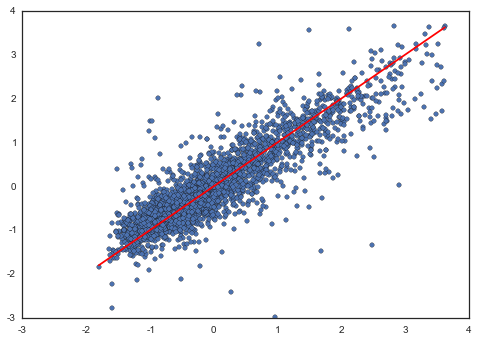

In [155]:
plt.scatter(Y,poly_regr.predict(poly.fit_transform(X)))
plt.ylim([-3,4])
plt.plot(np.linspace(Y_train.min(),Y_train.max(),num=10),np.linspace(Y_train.min(),Y_train.max(),num=10),color='red')

In [156]:
print('Variance score: %.5f\t(%.5f)' % (poly_regr.score(poly.fit_transform(X_test), Y_test), poly_regr.score(poly.fit_transform(X), Y)))

Variance score: -0.24850	(0.58188)


## Ridge regression

In [157]:
from sklearn import linear_model

In [158]:
rregr = linear_model.Ridge(alpha=0.5)
rregr.fit(X_train, Y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [159]:
print('Variance score: %.5f\t(%.5f)' % (rregr.score(X_test, Y_test), rregr.score(X_full, Y_full)))

Variance score: 0.72615	(0.69951)


In [160]:
scores_rregression = cross_validation.cross_val_score(rregr, X_train, Y_train, cv=cv, n_jobs=1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_rregression.mean(), scores_rregression.std() * 2))

Accuracy: 0.67 (+/- 0.06)


In [161]:
mse_rregression = mean_squared_error(Y_test, rregr.predict(X_test))
r2_rregression = r2_score(Y_test, rregr.predict(X_test))
r2_rregression, mse_rregression

(0.72615273036944972, 0.29076296530652646)

## Extra Trees Regression

In [162]:
from sklearn.ensemble import ExtraTreesRegressor

In [163]:
clf_et = ExtraTreesRegressor(n_estimators=250, bootstrap=True, oob_score=True, max_features='sqrt')
clf_et.fit(X_train, Y_train)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=250, n_jobs=1, oob_score=True, random_state=None,
          verbose=0, warm_start=False)

In [164]:
print('Variance score: %.5f\t(%.5f)\nOut of bag error score: %.5f' % (clf_et.score(X_test, Y_test), clf_et.score(X_full, Y_full),clf_et.oob_score_))

Variance score: 0.71822	(0.86916)
Out of bag error score: 0.69332


In [165]:
scores_etregression = cross_validation.cross_val_score(clf_et, X_train, Y_train, cv=cv, n_jobs=1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_etregression.mean(), scores_etregression.std() * 2))

Accuracy: 0.69 (+/- 0.04)


In [166]:
mse_etregression = mean_squared_error(Y_test, clf_et.predict(X_test))
r2_etregression = r2_score(Y_test, clf_et.predict(X_test))
r2_etregression, mse_etregression

(0.71822010273486103, 0.29918559569030667)

## Ada Boost Regressor

In [167]:
from sklearn.ensemble import AdaBoostRegressor

In [168]:
clf_ada = AdaBoostRegressor(n_estimators=400, learning_rate=0.1, loss='linear')
clf_ada.fit(X_train, Y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
         n_estimators=400, random_state=None)

In [169]:
print('Variance score: %.5f\t(%.5f)' % (clf_ada.score(X_test, Y_test), clf_ada.score(X_full, Y_full)))

Variance score: 0.67209	(0.66747)


In [170]:
scores_adaregression = cross_validation.cross_val_score(clf_ada, X_train, Y_train, cv=cv, n_jobs=1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_adaregression.mean(), scores_adaregression.std() * 2))

Accuracy: 0.62 (+/- 0.04)


In [171]:
mse_adaregression = mean_squared_error(Y_test, clf_ada.predict(X_test))
r2_adaregression = r2_score(Y_test, clf_ada.predict(X_test))
r2_adaregression, mse_adaregression

(0.67208733758838957, 0.34816800698063705)

## Bagging regressor

In [172]:
from sklearn.ensemble import BaggingRegressor

In [173]:
clf_bg = BaggingRegressor(n_estimators=250, bootstrap=True, oob_score=True, max_features=20)
clf_bg.fit(X_train, Y_train)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=20, max_samples=1.0,
         n_estimators=250, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

In [174]:
print('Variance score: %.5f\t(%.5f)' % (clf_bg.score(X_test, Y_test), clf_bg.score(X_full, Y_full)))

Variance score: 0.72421	(0.86342)


In [175]:
scores_bagregression = cross_validation.cross_val_score(clf_bg, X_train, Y_train, cv=cv, n_jobs=1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_bagregression.mean(), scores_bagregression.std() * 2))

Accuracy: 0.69 (+/- 0.04)


In [176]:
mse_bagregression = mean_squared_error(Y_test, clf_bg.predict(X_test))
r2_bagregression = r2_score(Y_test, clf_bg.predict(X_test))
r2_bagregression, mse_bagregression

(0.72421082670106296, 0.29282482142698929)

## Gradient Boosting Regressor

In [177]:
from sklearn.ensemble import GradientBoostingRegressor

In [178]:
clf_gb = GradientBoostingRegressor(n_estimators=100, max_features=30,max_depth=4)
clf_gb.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=30, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [179]:
print('Variance score: %.5f\t(%.5f)' % (clf_gb.score(X_test, Y_test), clf_gb.score(X_full, Y_full)))

Variance score: 0.72226	(0.80640)


/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


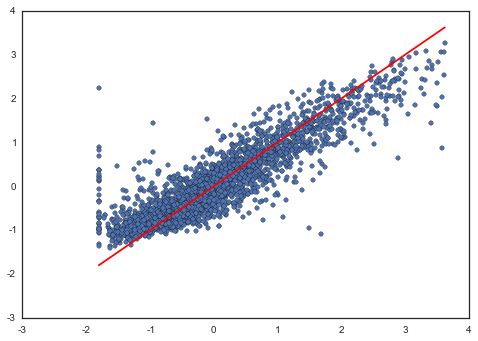

In [180]:
plt.scatter(Y_full,clf_gb.predict(X_full))
plt.plot(np.linspace(Y_full.min(),Y_full.max(),num=10),np.linspace(Y_full.min(),Y_full.max(),num=10),color='red')

In [181]:
scores_gradboostregression = cross_validation.cross_val_score(clf_gb, X_train, Y_train, cv=cv, n_jobs=1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_gradboostregression.mean(), scores_gradboostregression.std() * 2))

Accuracy: 0.68 (+/- 0.04)


In [182]:
mse_gradboostregression = mean_squared_error(Y_test, clf_gb.predict(X_test))
r2_gradboostregression = r2_score(Y_test, clf_gb.predict(X_test))
r2_gradboostregression, mse_gradboostregression

(0.7222602118042587, 0.29489592687321503)

In [183]:
clf_gb.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=30, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [184]:
import pickle

In [185]:
with open("../data/gradientboosting_params.pickle", "wb") as myfile:
    pickle.dump(clf_gb, myfile)

In [186]:
with open("../data/Ymean.pickle", "wb") as myfile:
    pickle.dump(Ymean, myfile)

In [187]:
with open("../data/Ystd.pickle", "wb") as myfile:
    pickle.dump(Ystd, myfile)

In [188]:
with open("../data/Xmeans.pickle", "wb") as myfile:
    pickle.dump(means, myfile)

In [189]:
with open("../data/Xstds.pickle", "wb") as myfile:
    pickle.dump(stds, myfile)

## Random forest

In [190]:
from sklearn.ensemble import RandomForestRegressor

In [212]:
df_merged = pd.read_csv("../data/chlamydia_cdc_census.csv")
df_new = df_merged.drop(["FIPS","Cases", "d002", "hd02s051", "hd02s143", "hd02s159", "hd02s184", "hd01s001"], axis=1)
#df_new = df_merged.drop(["FIPS","Cases"], axis=1)

In [213]:
df_new.head()

,Population,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s151,hd02s152,hd02s153,hd02s154,hd01s167,hd01s168,hd02s181,hd01vd01,d014,d019,d024,d029,lnd110210d
0,55246,21.8,7.9,5.6,5.8,6.1,7.6,7.5,15.0,10.7,12.0,37.0,48.7,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,74.5,34.9,56.2,25.3,2.68,3.13,75.4,52475,0.003017,0.020029,0.002868,0.017704,92.781808
1,195540,19.0,6.4,5.2,5.6,5.9,6.3,6.6,14.8,13.5,16.9,41.1,48.9,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,69.9,28.0,54.5,19.9,2.46,2.93,72.5,50183,0.002747,0.023886,0.003444,0.020292,122.920831
2,27076,18.0,6.3,6.5,7.3,6.6,6.6,6.6,14.7,13.2,14.3,39.0,53.1,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,68.4,27.4,43.7,14.4,2.47,3.01,66.8,35634,0.002342,0.019348,0.003666,0.022200,30.563959
3,22512,18.4,6.7,6.5,7.0,7.2,7.6,7.1,14.8,11.9,12.6,37.8,53.7,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,72.3,29.5,52.5,20.1,2.60,3.09,75.6,37984,0.001886,0.020244,0.002012,0.020370,36.101222
4,57872,20.2,7.0,5.4,6.0,6.0,6.8,7.0,14.1,12.6,14.6,39.0,49.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,75.0,31.1,60.6,24.1,2.63,3.07,80.6,44409,0.001946,0.017981,0.003707,0.013440,89.615659


In [214]:
cutoff = 1

X = df_new[df_merged["Cases"]>cutoff].values
Y = df_merged[df_merged["Cases"]>cutoff].Cases/(df_merged[df_merged["Cases"]>cutoff].Population+1.0)

X_full = df_new.values
Y_full = df_merged.Cases/(df_merged.Population+1.0)

#normalize all columns and the full dataset to the same normalization
columns = X.shape[1]
means = np.zeros(columns)
stds = np.zeros(columns)
for column in np.arange(columns):
    mean_temp = X[:,column].mean()
    std_temp = X[:,column].std()
    means[column] = mean_temp
    stds[column] = std_temp
    X[:,column] = (X[:,column]-mean_temp)/std_temp
    X_full[:,column] = (X_full[:,column]-mean_temp)/std_temp


Ymean = Y.mean()
Ystd = Y.std()

Y = (Y-Ymean)/Ystd
Y_full = (Y_full-Ymean)/Ystd

#split into training/validation and test data
ones = np.ones(round(0.75*len(X)), dtype=bool)
zeros = np.zeros(len(X)-round(0.75*len(X)), dtype=bool)
training_list = np.hstack((ones, zeros))
np.random.shuffle(training_list)
test_list = np.zeros(len(X),dtype=bool)
test_list = np.array([not i for i in training_list])

X_train = X[training_list]
X_test = X[test_list]
Y_train = Y[training_list]
Y_test = Y[test_list]

In [215]:
clf = RandomForestRegressor(n_estimators=250, oob_score=True, max_features='sqrt',min_samples_split=2, n_jobs=4)
clf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=4, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [216]:
print('Variance score: %.5f\t(%.5f)\nOut of bag error score: %.5f' % (clf.score(X_test, Y_test), clf.score(X_full, Y_full),clf.oob_score_))

Variance score: 0.69043	(0.86782)
Out of bag error score: 0.71409


In [217]:
scores_randomforest = cross_validation.cross_val_score(clf, X_train, Y_train, cv=cv, n_jobs=4)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_randomforest.mean(), scores_randomforest.std()/np.sqrt(5) * 2))

Accuracy: 0.70 (+/- 0.03)


In [218]:
mse_randomforest = mean_squared_error(Y_test, clf.predict(X_test))
r2_randomforest = r2_score(Y_test, clf.predict(X_test))
r2_randomforest, mse_randomforest

(0.69042758416100392, 0.26118036453623333)

In [219]:
clf = RandomForestRegressor(n_estimators=250, oob_score=True, max_features='sqrt',min_samples_split=2, n_jobs=4)
clf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=4, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [220]:
mean_squared_error(Y_train, clf.predict(X_train))

0.041136663589541399

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


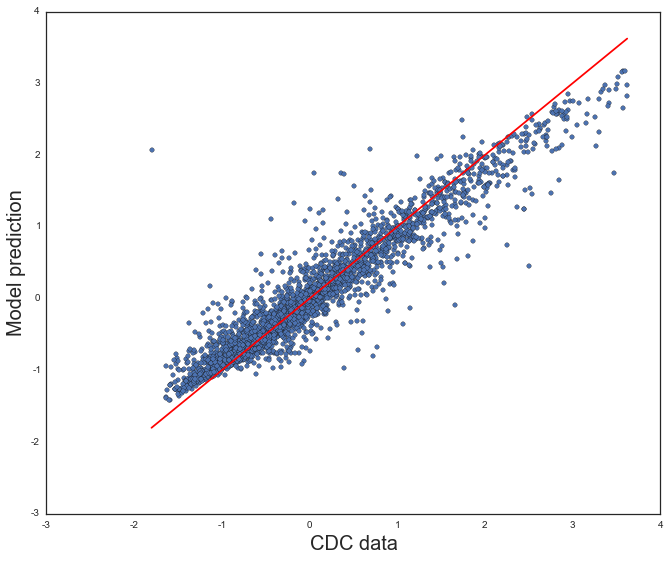

In [221]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

#ax.text(-1.5, 3, r'$R^2 = $%.2f'%(clf.oob_score_), fontsize=30)


ax.set_xlabel("CDC data", fontsize=20)
ax.set_ylabel("Model prediction", fontsize=20)

ax = plt.scatter(Y,clf.predict(X))
ax2 = plt.plot(np.linspace(Y.min(),Y.max(),10),np.linspace(Y.min(),Y.max(),10),color='red')

plt.savefig('../graphics/data_vs_model.png', bbox_inches='tight', dpi=150)

/Users/akuepper/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/akuepper/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/akuepper/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


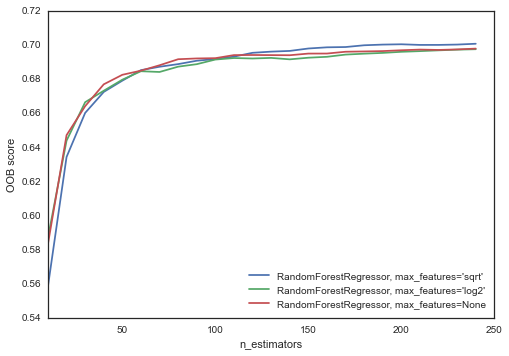

In [1041]:
from collections import OrderedDict
RANDOM_STATE = 123
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=False, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(warm_start=False, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=False, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 250

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators,10):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, Y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB score")
plt.legend(loc="lower right")

plt.savefig('../graphics/features_estimators.png', bbox_inches='tight', dpi=150)

In [302]:
feature_importance = (np.vstack((np.arange(len(clf.feature_importances_)), clf.feature_importances_)).T)
ranking = feature_importance[feature_importance[:,1].argsort()[::-1]]

In [303]:
for rank, importance in ranking: 
    print(df_new.columns[rank], importance)

hd02s078 0.144057762832
hd02s133 0.114593302221
hd02s153 0.0944768935969
hd02s079 0.0931076237628
hd02s136 0.0529719710444
hd02s181 0.0522052500132
hd02s006 0.0380873475666
hd02s026 0.0262301134961
hd01s020 0.0251270992531
hd02s011 0.0212871319312
hd02s007 0.0206754300116
d029 0.0184548253195
hd02s154 0.0166790487052
hd02s095 0.0156522954193
hd02s002 0.0150027997785
hd01s168 0.0139175648431
hd02s013 0.0135707572989
hd01vd01 0.0135224494918
Population 0.01307569505
d019 0.0119547278008
hd02s010 0.0118094949592
hd02s107 0.0114583881327
lnd110210d 0.0111944526745
hd02s151 0.0111859535143
hd02s015 0.0111024284699
hd02s134 0.0109745647401
d024 0.0107914503367
hd02s005 0.0106431149122
hd02s135 0.0104960037432
hd02s080 0.0102299053654
hd02s132 0.010100977831
hd02s131 0.00980512358664
d014 0.00955053242073
hd02s152 0.0093103734816
hd02s008 0.00916808307527
hd01s167 0.00914088683805
hd02s009 0.00837260888665
hd02s081 0.00785660274948
hd02s089 0.00215896484623


In [304]:
labels_dict = {
    "Population": "Population",
    "hd01s001":  "log10(Population)",
    "hd02s002":  "0-14",
    "hd02s005":  "15-19",
    "hd02s006":  "20-24",
    "hd02s007":  "25-29",
    "hd02s008":  "30-34",
    "hd02s009":  "35-39",
    "hd02s010":  "40-44",
    "hd02s011":  "45-54",
    "hd02s013":  "55-64",
    "hd02s015":  "65+",
    "hd01s020":  "Median age",
    "hd02s026":  "Male percent",
    "hd02s051":  "Female percent",
    "hd02s078":  "White",
    "hd02s079":  "Black",
    "hd02s080":  "Native",
    "hd02s081":  "Asian",
    "hd02s089":  "Pacific/Hawaiian",
    "hd02s095":  "Two or more races",
    "hd02s107":  "Hispanic",
    "hd02s131":  "In households",
    "hd02s132":  "Householder",
    "hd02s133":  "Spouse",
    "hd02s134":  "Child",
    "hd02s135":  "Child w own child under 18",
    "hd02s136":  "Other relatives",
    "hd02s143":  "In group quarters",
    "hd02s151":  "Family households",
    "hd02s152":  "Family households w own child under 18",
    "hd02s153":  "Husband-wife family",
    "hd02s154":  "Husband-wife family w own child under 18",
    "hd02s159":  "Nonfamily households",
    "hd01s167":  "Average household size",
    "hd01s168":  "Average family size",
    "hd02s181":  "Owner occupied housing units",
    "hd02s184":  "Renter occupied housing units",
    "hd01vd01":  "Median income",
    "d001":      "Total households",
    "d002":      "Husband-wife households",
    "d014":      "Unmarried-partner households: - Male householder and male partner",
    "d019":      "Unmarried-partner households: - Male householder and female partner",
    "d024":      "Unmarried-partner households: - Female householder and female partner",
    "d029":      "Unmarried-partner households: - Female householder and male partner",
    "lnd110210d": "Population density"}

In [305]:
ranked_list = []
ranked_labels = []
for rank, importance in ranking: 
    print(labels_dict[df_new.columns[rank]], importance)
    ranked_list.append(importance)
    ranked_labels.append(labels_dict[df_new.columns[rank]])
len(ranked_labels)

White 0.144057762832
Spouse 0.114593302221
Husband-wife family 0.0944768935969
Black 0.0931076237628
Other relatives 0.0529719710444
Owner occupied housing units 0.0522052500132
20-24 0.0380873475666
Male percent 0.0262301134961
Median age 0.0251270992531
45-54 0.0212871319312
25-29 0.0206754300116
Unmarried-partner households: - Female householder and male partner 0.0184548253195
Husband-wife family w own child under 18 0.0166790487052
Two or more races 0.0156522954193
0-14 0.0150027997785
Average family size 0.0139175648431
55-64 0.0135707572989
Median income 0.0135224494918
Population 0.01307569505
Unmarried-partner households: - Male householder and female partner 0.0119547278008
40-44 0.0118094949592
Hispanic 0.0114583881327
Population density 0.0111944526745
Family households 0.0111859535143
65+ 0.0111024284699
Child 0.0109745647401
Unmarried-partner households: - Female householder and female partner 0.0107914503367
15-19 0.0106431149122
Child w own child under 18 0.010496003743

39

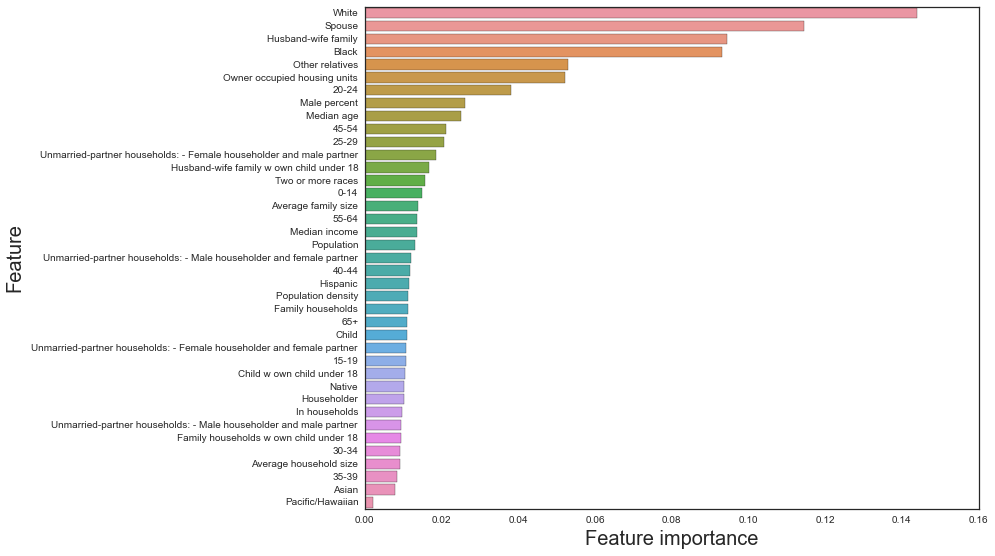

In [306]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax.set_xlabel("Feature importance", fontsize=20)
ax.set_ylabel("Feature", fontsize=20)

ax = sns.barplot(x=ranked_list, y=ranked_labels)
plt.savefig('../graphics/feature_importance_ranking.png', bbox_inches='tight', dpi=150)

In [307]:
len(ranked_list)

39

Save model parameters for use in web app:

In [222]:
import pickle

In [223]:
with open("../data/randomforest_params.pickle", "wb") as myfile:
    pickle.dump(clf, myfile)

In [224]:
with open("../data/Ymean.pickle", "wb") as myfile:
    pickle.dump(Ymean, myfile)

In [225]:
with open("../data/Ystd.pickle", "wb") as myfile:
    pickle.dump(Ystd, myfile)

In [226]:
with open("../data/Xmeans.pickle", "wb") as myfile:
    pickle.dump(means, myfile)

In [227]:
with open("../data/Xstds.pickle", "wb") as myfile:
    pickle.dump(stds, myfile)

In [228]:
deployed_model = pickle.load(open('../data/randomforest_params.pickle', "rb" ))

In [229]:
print('Variance score: %.5f\t(%.5f)' % (deployed_model.score(X_test, Y_test), deployed_model.score(X_full, Y_full)))

Variance score: 0.69430	(0.87140)


## Suport Vector Regression

In [316]:
from sklearn.svm import SVR

In [317]:
svr_rbf = SVR(kernel='rbf', C=15, gamma=0.0001, epsilon=0.0005, tol=0.00001)
#svr_lin = SVR(kernel='linear', C=1, epsilon=0.001)
#svr_poly = SVR(kernel='poly', C=1, degree=2, epsilon=0.001)
svr_rbf.fit(X_train, Y_train)
#svr_lin.fit(X_train, Y_train)
#svr_poly.fit(X_train, Y_train)
#print('Variance score:\n\t%.5f\t(rbf)\n\t%.5f\t(lin)\n\t%.5f\t(poly)' % (svr_rbf.score(X_train, Y_train), svr_lin.score(X_train, Y_train),svr_poly.score(X_train, Y_train)))
print('Variance score:\n\t%.5f\t(rbf)' % (svr_rbf.score(X_test, Y_test)))

Variance score:
	0.65632	(rbf)


In [318]:
scores_svm = cross_validation.cross_val_score(svr_rbf, X_train, Y_train, cv=cv, n_jobs=1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))

Accuracy: 0.69 (+/- 0.06)


In [319]:
mse_svm = mean_squared_error(Y_test, svr_rbf.predict(X_test))
r2_svm = r2_score(Y_test, svr_rbf.predict(X_test))
r2_svm, mse_svm

(0.65631709963885099, 0.333420400365597)

## Model comparison

In [324]:
model_scores = []
model_errors = []
model_names = []
model_scores.append(np.mean(scores_regression))
model_errors.append(np.std(scores_regression)*2)
model_names.append("Linear")
model_scores.append(np.mean(scores_rregression))
model_errors.append(np.std(scores_rregression)*2)
model_names.append("Ridge")
model_scores.append(np.mean(scores_etregression))
model_errors.append(np.std(scores_etregression)*2)
model_names.append("Extra trees")
model_scores.append(np.mean(scores_adaregression))
model_errors.append(np.std(scores_adaregression)*2)
model_names.append("ADA boost")
model_scores.append(np.mean(scores_bagregression))
model_errors.append(np.std(scores_bagregression)*2)
model_names.append("Bagging")
model_scores.append(np.mean(scores_gradboostregression))
model_errors.append(np.std(scores_gradboostregression)*2)
model_names.append("Gradient boost")
model_scores.append(np.mean(scores_svm))
model_errors.append(np.std(scores_svm)*2)
model_names.append("Suport vector")
model_scores.append(np.mean(scores_randomforest))
model_errors.append(np.std(scores_randomforest)*2)
model_names.append("Random forest")

In [325]:
model_names, model_scores, model_errors

(['Linear',
  'Ridge',
  'Extra trees',
  'ADA boost',
  'Bagging',
  'Gradient boost',
  'Suport vector',
  'Random forest'],
 [0.69773646714589233,
  0.69896251726782066,
  0.70935570103115064,
  0.65739722946177714,
  0.71605884059447777,
  0.71149113629088612,
  0.68740286715362442,
  0.71445168147934224],
 [0.065006462076724919,
  0.061900224714161713,
  0.045663766349166787,
  0.052374312757283943,
  0.053423486020176741,
  0.054480396511430593,
  0.057537543151294827,
  0.049048305905312527])

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


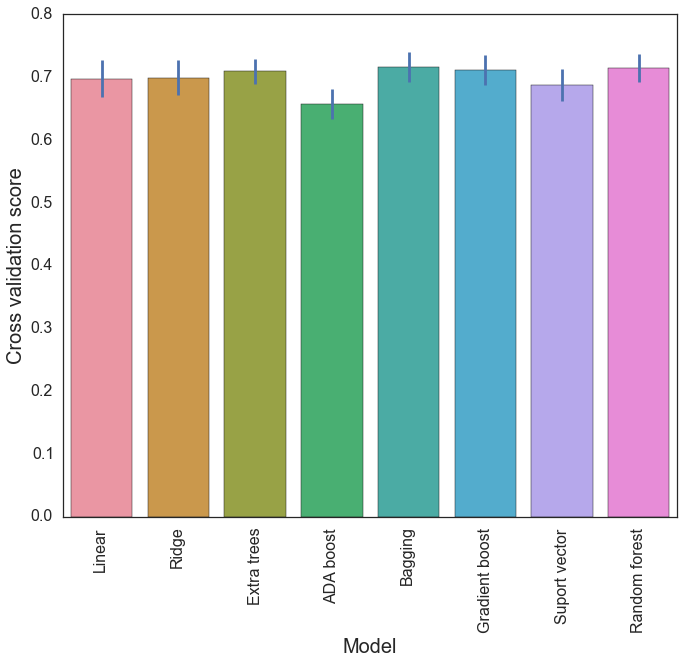

In [326]:
# Set up the matplotlib figure
sns.set_context("poster", font_scale=1)
f, ax = plt.subplots(figsize=(11, 9))

ax.set_xlabel("Model", fontsize=20)
ax.set_ylabel("Cross validation score", fontsize=20)

ax = sns.barplot(x=model_names, y=model_scores, yerr=model_errors/np.sqrt(5))
plt.xticks(rotation=90)
plt.savefig('../graphics/model_performance.png', bbox_inches='tight', dpi=150)

## Stacking of multiple regressors

In [327]:
from mlxtend.regressor import StackingRegressor

Mean Squared Error: 0.3097
Variance Score: 0.6808


/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


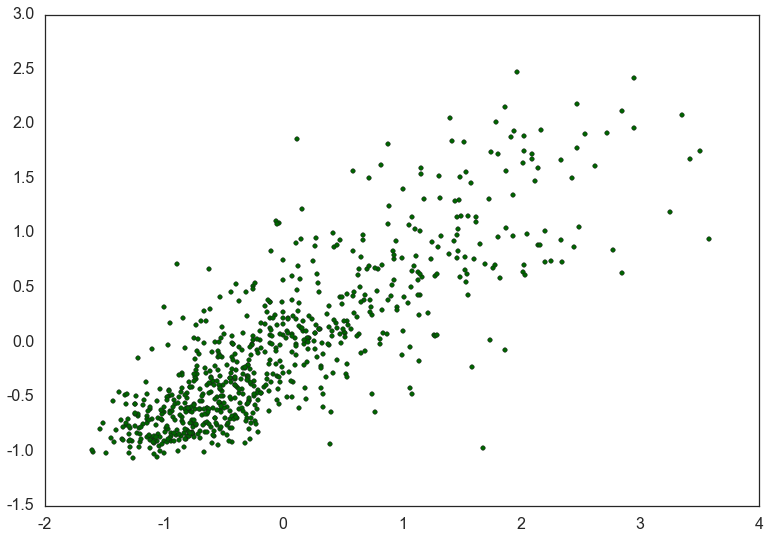

In [328]:
svr_rbf_meta = SVR(kernel='rbf', C=1, gamma=0.0001, epsilon=0.1, tol=0.001)

stregr = StackingRegressor(regressors=[regr, rregr, clf_et, clf_ada, clf_bg, clf_gb, clf, svr_rbf], 
                           meta_regressor=svr_rbf_meta)

# Training the stacking classifier

stregr.fit(X_train, Y_train)
stregr.predict(X_train)

# Evaluate and visualize the fit

print("Mean Squared Error: %.4f"
      % np.mean((stregr.predict(X_test) - Y_test) ** 2))
print('Variance Score: %.4f' % stregr.score(X_test, Y_test))

#plt.scatter(X, Y, c='lightgray')
plt.scatter(Y_test, stregr.predict(X_test), c='darkgreen')


In [329]:
scores_meta = cross_validation.cross_val_score(stregr, X_train, Y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_meta.mean(), scores_meta.std()/np.sqrt(5) * 2))

Accuracy: 0.71 (+/- 0.02)


In [330]:
scores_meta

array([ 0.72844863,  0.72996116,  0.70272817,  0.65589139,  0.73752242,
        0.70002914,  0.72647436,  0.71233904,  0.67606425,  0.70390804])

## Census data on ZIP code level

In [331]:
df_census_zip = pd.read_csv("../data/census/DEC_10_general_zipcode.csv", header=0, skiprows={1})

In [332]:
df_census_zip.head()

,GEO.id,GEO.id2,GEO.display-label,HD01_S001,HD02_S001,HD01_S002,HD02_S002,HD01_S003,HD02_S003,HD01_S004,HD02_S004,HD01_S005,HD02_S005,HD01_S006,HD02_S006,HD01_S007,HD02_S007,HD01_S008,HD02_S008,HD01_S009,HD02_S009,HD01_S010,HD02_S010,HD01_S011,HD02_S011,HD01_S012,HD02_S012,HD01_S013,HD02_S013,HD01_S014,HD02_S014,HD01_S015,HD02_S015,HD01_S016,HD02_S016,HD01_S017,HD02_S017,HD01_S018,HD02_S018,HD01_S019,HD02_S019,HD01_S020,HD02_S020,HD01_S021,HD02_S021,HD01_S022,HD02_S022,HD01_S023,HD02_S023,HD01_S024,HD02_S024,HD01_S025,HD02_S025,HD01_S026,HD02_S026,HD01_S027,HD02_S027,HD01_S028,HD02_S028,HD01_S029,HD02_S029,HD01_S030,HD02_S030,HD01_S031,HD02_S031,HD01_S032,HD02_S032,HD01_S033,HD02_S033,HD01_S034,HD02_S034,HD01_S035,HD02_S035,HD01_S036,HD02_S036,HD01_S037,HD02_S037,HD01_S038,HD02_S038,HD01_S039,HD02_S039,HD01_S040,HD02_S040,HD01_S041,HD02_S041,HD01_S042,HD02_S042,HD01_S043,HD02_S043,HD01_S044,HD02_S044,HD01_S045,HD02_S045,HD01_S046,HD02_S046,HD01_S047,HD02_S047,HD01_S048,HD02_S048,HD01_S049,...,HD01_S137,HD02_S137,HD01_S138,HD02_S138,HD01_S139,HD02_S139,HD01_S140,HD02_S140,HD01_S141,HD02_S141,HD01_S142,HD02_S142,HD01_S143,HD02_S143,HD01_S144,HD02_S144,HD01_S145,HD02_S145,HD01_S146,HD02_S146,HD01_S147,HD02_S147,HD01_S148,HD02_S148,HD01_S149,HD02_S149,HD01_S150,HD02_S150,HD01_S151,HD02_S151,HD01_S152,HD02_S152,HD01_S153,HD02_S153,HD01_S154,HD02_S154,HD01_S155,HD02_S155,HD01_S156,HD02_S156,HD01_S157,HD02_S157,HD01_S158,HD02_S158,HD01_S159,HD02_S159,HD01_S160,HD02_S160,HD01_S161,HD02_S161,HD01_S162,HD02_S162,HD01_S163,HD02_S163,HD01_S164,HD02_S164,HD01_S165,HD02_S165,HD01_S166,HD02_S166,HD01_S167,HD02_S167,HD01_S168,HD02_S168,HD01_S169,HD02_S169,HD01_S170,HD02_S170,HD01_S171,HD02_S171,HD01_S172,HD02_S172,HD01_S173,HD02_S173,HD01_S174,HD02_S174,HD01_S175,HD02_S175,HD01_S176,HD02_S176,HD01_S177,HD02_S177,HD01_S178,HD02_S178,HD01_S179,HD02_S179,HD01_S180,HD02_S180,HD01_S181,HD02_S181,HD01_S182,HD02_S182,HD01_S183,HD02_S183,HD01_S184,HD02_S184,HD01_S185,HD02_S185,HD01_S186,HD02_S186
0,8600000US00601,601,ZCTA5 00601,18570,100,1142,6.1,1245,6.7,1440,7.8,1558,8.4,1302,7,1281,6.9,1139,6.1,1043,5.6,1231,6.6,1235,6.7,1224,6.6,1204,6.5,1063,5.7,843,4.5,604,3.3,443,2.4,283,1.5,290,1.6,35.9,( X ),14436,77.7,13806,74.3,12896,69.4,3116,16.8,2463,13.3,9078,48.9,569,3.1,643,3.5,716,3.9,847,4.6,665,3.6,614,3.3,528,2.8,492,2.6,582,3.1,597,3.2,597,3.2,568,3.1,525,2.8,396,2.1,283,1.5,221,1.2,126,0.7,109,0.6,34.5,( X ),6984,37.6,6644,35.8,6163,33.2,1449,...,538,2.9,188,1,447,2.4,27,0.1,34,0.2,357,1.9,62,0.3,57,0.3,27,0.1,30,0.2,5,0,2,0,3,0,6525,100,5078,77.8,2261,34.7,3415,52.3,1465,22.5,336,5.1,171,2.6,1327,20.3,625,9.6,1447,22.2,1323,20.3,667,10.2,214,3.3,656,10.1,361,5.5,2579,39.5,1889,29,2.84,( X ),3.27,( X ),7744,100,6525,84.3,1219,15.7,222,2.9,15,0.2,36,0.5,39,0.5,312,4,595,7.7,0.8,( X ),9.4,( X ),6525,100,4392,67.3,12392,( X ),2.82,( X ),2133,32.7,6116,( X ),2.87,( X )
1,8600000US00602,602,ZCTA5 00602,41520,100,2291,5.5,2488,6,3028,7.3,3264,7.9,3007,7.2,2635,6.3,2793,6.7,2557,6.2,2965,7.1,3120,7.5,3028,7.3,2792,6.7,2368,5.7,1844,4.4,1380,3.3,986,2.4,546,1.3,428,1,37.5,( X ),33034,79.6,31696,76.3,29805,71.8,6642,16,5184,12.5,20396,49.1,1173,2.8,1271,3.1,1524,3.7,1647,4,1514,3.6,1299,3.1,1380,3.3,1286,3.1,1413,3.4,1497,3.6,1447,3.5,1370,3.3,1138,2.7,913,2.2,669,1.6,422,1,246,0.6,187,0.5,36.6,( X ),16079,38.7,15402,37.1,14441,34.8,3125,...,1128,2.7,341,0.8,853,2.1,38,0.1,63,0.2,669,1.6,71,0.2,12,0,12,0,0,0,59,0.1,31,0.1,28,0.1,15002,100,11646,77.6,4906,32.7,8272,55.1,3397,22.6,766,5.1,311,2.1,2608,17.4,1198,8,3356,22.4,3071,20.5,1573,10.5,453,3,1498,10,733,4.9,5635,37.6,3891,25.9,2.76,( X ),3.20,( X ),18073,100,15002,83,3071,17,466,2.6,43,0.2,230,1.3,80,0.4,799,4.4,1453,8,1.9,( X ),12,( X ),15002,100,11620,77.5,32580,( X ),2.80,( X ),3382,22.5,8869,( X ),2.62,( X )
2,8600000US00603,603,ZCTA5 00603,54689,100,3245,5.9,3439,6.3,3810,7,3961,7.2,3584,6.6,3510,6.4,3566,6.5,3529,6.5,3444,6.3,3475,6.4,3524,6.4,3372,6.2,3619,6.6,2947,5.4,2228,4.1,1588,2.9,101

In [333]:
columnnames = list(df_census_zip.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    #print(columnname_wo_specialcharacters.lower())
    df_census_zip.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)


In [334]:
df_census_zip_clean = df_census_zip.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_zip_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid               object
geoid2               int64
geodisplaylabel     object
hd01s001             int64
hd02s001           float64
hd01s002             int64
hd02s002           float64
hd01s003             int64
hd02s003           float64
hd01s004             int64
hd02s004           float64
hd01s005             int64
hd02s005           float64
hd01s006             int64
hd02s006           float64
hd01s007             int64
hd02s007           float64
hd01s008             int64
hd02s008           float64
hd01s009             int64
hd02s009           float64
hd01s010             int64
hd02s010           float64
hd01s011             int64
hd02s011           float64
hd01s012             int64
hd02s012           float64
hd01s013             int64
hd02s013           float64
hd01s014             int64
                    ...   
hd01s172             int64
hd02s172           float64
hd01s173             int64
hd02s173           float64
hd01s174             int64
hd02s174           float64
h

In [335]:
df_census_zip_clean.describe()

,geoid2,hd01s001,hd02s001,hd01s002,hd02s002,hd01s003,hd02s003,hd01s004,hd02s004,hd01s005,hd02s005,hd01s006,hd02s006,hd01s007,hd02s007,hd01s008,hd02s008,hd01s009,hd02s009,hd01s010,hd02s010,hd01s011,hd02s011,hd01s012,hd02s012,hd01s013,hd02s013,hd01s014,hd02s014,hd01s015,hd02s015,hd01s016,hd02s016,hd01s017,hd02s017,hd01s018,hd02s018,hd01s019,hd02s019,hd01s020,hd01s021,hd02s021,hd01s022,hd02s022,hd01s023,hd02s023,hd01s024,hd02s024,hd01s025,hd02s025,hd01s026,hd02s026,hd01s027,hd02s027,hd01s028,hd02s028,hd01s029,hd02s029,hd01s030,hd02s030,hd01s031,hd02s031,hd01s032,hd02s032,hd01s033,hd02s033,hd01s034,hd02s034,hd01s035,hd02s035,hd01s036,hd02s036,hd01s037,hd02s037,hd01s038,hd02s038,hd01s039,hd02s039,hd01s040,hd02s040,hd01s041,hd02s041,hd01s042,hd02s042,hd01s043,hd02s043,hd01s044,hd02s044,hd01s045,hd01s046,hd02s046,hd01s047,hd02s047,hd01s048,hd02s048,hd01s049,hd02s049,hd01s050,hd02s050,hd01s051,...,hd01s133,hd02s133,hd01s134,hd02s134,hd01s135,hd02s135,hd01s136,hd02s136,hd01s137,hd02s137,hd01s138,hd02s138,hd01s139,hd02s139,hd01s140,hd02s140,hd01s141,hd02s141,hd01s142,hd02s142,hd01s143,hd02s143,hd01s144,hd02s144,hd01s145,hd02s145,hd01s146,hd02s146,hd01s147,hd02s147,hd01s148,hd02s148,hd01s149,hd02s149,hd01s150,hd02s150,hd01s151,hd02s151,hd01s152,hd02s152,hd01s153,hd02s153,hd01s154,hd02s154,hd01s155,hd02s155,hd01s156,hd02s156,hd01s157,hd02s157,hd01s158,hd02s158,hd01s159,hd02s159,hd01s160,hd02s160,hd01s161,hd02s161,hd01s162,hd02s162,hd01s163,hd02s163,hd01s164,hd02s164,hd01s165,hd02s165,hd01s166,hd02s166,hd01s167,hd01s168,hd01s169,hd02s169,hd01s170,hd02s170,hd01s171,hd02s171,hd01s172,hd02s172,hd01s173,hd02s173,hd01s174,hd02s174,hd01s175,hd02s175,hd01s176,hd02s176,hd01s177,hd02s177,hd01s178,hd01s179,hd01s180,hd02s180,hd01s181,hd02s181,hd01s182,hd01s183,hd01s184,hd02s184,hd01s185,hd01s186
count,33120.000000,33120.000000,32976,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,...,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32803,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,3312

In [336]:
df_census_zip_subset = df_census_zip_clean[["geoid2",
                                    "hd01s001",  #population
                                    "hd02s002",  #under 5 yrs
                                    "hd02s003",  #5-9 yrs 
                                    "hd02s004",  #10-14
                                    "hd02s005",  #15-19
                                    "hd02s006",  #20-24
                                    "hd02s007",  #25-29
                                    "hd02s008",  #30-34
                                    "hd02s009",  #35-39
                                    "hd02s010",  #40-44
                                    "hd02s011",  #45-49
                                    "hd02s012",  #50-54
                                    "hd02s013",  #55-59
                                    "hd02s014",  #60-64
                                    "hd02s015",  #65-69
                                    "hd02s016",  #70-74
                                    "hd02s017",  #75-79
                                    "hd02s018",  #80-84
                                    "hd02s019",  #85 and over
                                    "hd01s020",  #median age
                                    "hd02s026",  #male percent
                                    "hd02s051",  #female percent
                                    "hd02s078",  #white
                                    "hd02s079",  #black
                                    "hd02s080",  #native
                                    "hd02s081",  #asian
                                    "hd02s089",  #pacific
                                    "hd02s095",  #two or more
                                    "hd02s107",  #hispanic
                                    "hd02s131",  #in households
                                    "hd02s132",  #householder
                                    "hd02s133",  #spouse
                                    "hd02s134",  #child
                                    "hd02s135",  #child w own child under 18
                                    "hd02s136",  #other relatives
                                    "hd02s143",  #in group quarters
                                    "hd02s151",  #family households
                                    "hd02s152",  #family households w own child under 18
                                    "hd02s153",  #husband-wife family
                                    "hd02s154",  #husband-wife family w own child under 18
                                    "hd02s159",  #nonfamily households
                                    "hd01s167",  #average household size
                                    "hd01s168",  #average family size
                                    "hd02s181",  #owner occupied housing units
                                    "hd02s184"   #renter occupied housing units
                                   ]].copy()
df_census_zip_subset.head()

,geoid2,hd01s001,hd02s002,hd02s003,hd02s004,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s012,hd02s013,hd02s014,hd02s015,hd02s016,hd02s017,hd02s018,hd02s019,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184
0,601,18570,6.1,6.7,7.8,8.4,7.0,6.9,6.1,5.6,6.6,6.7,6.6,6.5,5.7,4.5,3.3,2.4,1.5,1.6,35.9,48.9,51.1,93.1,3.1,0.4,0.0,0.0,1.3,99.5,99.7,35.1,18.4,37.5,22.5,6.2,0.3,77.8,34.7,52.3,22.5,22.2,2.84,3.27,67.3,32.7
1,602,41520,5.5,6.0,7.3,7.9,7.2,6.3,6.7,6.2,7.1,7.5,7.3,6.7,5.7,4.4,3.3,2.4,1.3,1.0,37.5,49.1,50.9,86.7,5.3,0.3,0.1,0.0,2.4,99.4,99.8,36.1,19.9,35.6,20.8,6.1,0.2,77.6,32.7,55.1,22.6,22.4,2.76,3.20,77.5,22.5
2,603,54689,5.9,6.3,7.0,7.2,6.6,6.4,6.5,6.5,6.3,6.4,6.4,6.2,6.6,5.4,4.1,2.9,1.8,1.5,38.2,48.6,51.4,82.9,7.6,0.3,0.2,0.0,2.5,98.5,97.9,38.7,17.2,32.9,20.6,6.6,2.1,71.1,29.8,44.4,17.1,28.9,2.53,3.06,64.9,35.1
3,606,6615,6.6,6.2,7.4,7.7,7.8,6.9,6.1,6.0,6.4,6.7,6.9,6.5,6.0,4.5,3.1,2.4,1.3,1.6,36.2,49.4,50.6,88.9,4.7,0.4,0.0,0.1,1.5,99.4,99.8,36.3,18.2,34.9,21.3,7.7,0.2,74.6,31.6,50.0,20.8,25.4,2.75,3.24,72.3,27.7
4,610,29016,5.7,6.1,7.6,7.5,6.4,6.2,6.7,6.7,7.1,6.8,6.6,6.0,6.2,5.0,4.1,2.6,1.5,1.3,38.1,48.6,51.4,82.0,7.2,0.3,0.1,0.0,2.8,99.2,99.6,37.3,18.5,33.8,20.7,7.2,0.4,74.4,31.2,49.6,19.9,25.6,2.67,3.14,77.5,22.5


In [337]:
df_census_zip_subset['hd02s002'] = df_census_zip_subset['hd02s002']+df_census_zip_subset['hd02s003']+df_census_zip_subset['hd02s004'] 
df_census_zip_subset['hd02s011'] = df_census_zip_subset['hd02s011']+df_census_zip_subset['hd02s012'] 
df_census_zip_subset['hd02s013'] = df_census_zip_subset['hd02s013']+df_census_zip_subset['hd02s014'] 
df_census_zip_subset['hd02s015'] = df_census_zip_subset['hd02s015']+df_census_zip_subset['hd02s016']+df_census_zip_subset['hd02s017']+df_census_zip_subset['hd02s018']+df_census_zip_subset['hd02s019']

In [338]:
df_census_zip_combined_subset = df_census_zip_subset[["geoid2",
                                    "hd01s001",  #log10(population)
                                    "hd02s002",  #0-14
                                    "hd02s005",  #15-19
                                    "hd02s006",  #20-24
                                    "hd02s007",  #25-29
                                    "hd02s008",  #30-34
                                    "hd02s009",  #35-39
                                    "hd02s010",  #40-44
                                    "hd02s011",  #45-54
                                    "hd02s013",  #55-64
                                    "hd02s015",  #65+
                                    "hd01s020",  #median age
                                    "hd02s026",  #male percent
                                    "hd02s051",  #female percent
                                    "hd02s078",  #white
                                    "hd02s079",  #black
                                    "hd02s080",  #native
                                    "hd02s081",  #asian
                                    "hd02s089",  #pacific
                                    "hd02s095",  #two or more
                                    "hd02s107",  #hispanic
                                    "hd02s131",  #in households
                                    "hd02s132",  #householder
                                    "hd02s133",  #spouse
                                    "hd02s134",  #child
                                    "hd02s135",  #child w own child under 18
                                    "hd02s136",  #other relatives
                                    "hd02s143",  #in group quarters
                                    "hd02s151",  #family households
                                    "hd02s152",  #family households w own child under 18
                                    "hd02s153",  #husband-wife family
                                    "hd02s154",  #husband-wife family w own child under 18
                                    "hd02s159",  #nonfamily households
                                    "hd01s167",  #average household size
                                    "hd01s168",  #average family size
                                    "hd02s181",  #owner occupied housing units
                                    "hd02s184"   #renter occupied housing units
                                   ]].copy()
df_census_zip_combined_subset.head()

,geoid2,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184
0,601,18570,20.6,8.4,7.0,6.9,6.1,5.6,6.6,13.3,12.2,13.3,35.9,48.9,51.1,93.1,3.1,0.4,0.0,0.0,1.3,99.5,99.7,35.1,18.4,37.5,22.5,6.2,0.3,77.8,34.7,52.3,22.5,22.2,2.84,3.27,67.3,32.7
1,602,41520,18.8,7.9,7.2,6.3,6.7,6.2,7.1,14.8,12.4,12.4,37.5,49.1,50.9,86.7,5.3,0.3,0.1,0.0,2.4,99.4,99.8,36.1,19.9,35.6,20.8,6.1,0.2,77.6,32.7,55.1,22.6,22.4,2.76,3.20,77.5,22.5
2,603,54689,19.2,7.2,6.6,6.4,6.5,6.5,6.3,12.8,12.8,15.7,38.2,48.6,51.4,82.9,7.6,0.3,0.2,0.0,2.5,98.5,97.9,38.7,17.2,32.9,20.6,6.6,2.1,71.1,29.8,44.4,17.1,28.9,2.53,3.06,64.9,35.1
3,606,6615,20.2,7.7,7.8,6.9,6.1,6.0,6.4,13.6,12.5,12.9,36.2,49.4,50.6,88.9,4.7,0.4,0.0,0.1,1.5,99.4,99.8,36.3,18.2,34.9,21.3,7.7,0.2,74.6,31.6,50.0,20.8,25.4,2.75,3.24,72.3,27.7
4,610,29016,19.4,7.5,6.4,6.2,6.7,6.7,7.1,13.4,12.2,14.5,38.1,48.6,51.4,82.0,7.2,0.3,0.1,0.0,2.8,99.2,99.6,37.3,18.5,33.8,20.7,7.2,0.4,74.4,31.2,49.6,19.9,25.6,2.67,3.14,77.5,22.5


In [339]:
df_census_zip_subset.head()

,geoid2,hd01s001,hd02s002,hd02s003,hd02s004,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s012,hd02s013,hd02s014,hd02s015,hd02s016,hd02s017,hd02s018,hd02s019,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184
0,601,18570,20.6,6.7,7.8,8.4,7.0,6.9,6.1,5.6,6.6,13.3,6.6,12.2,5.7,13.3,3.3,2.4,1.5,1.6,35.9,48.9,51.1,93.1,3.1,0.4,0.0,0.0,1.3,99.5,99.7,35.1,18.4,37.5,22.5,6.2,0.3,77.8,34.7,52.3,22.5,22.2,2.84,3.27,67.3,32.7
1,602,41520,18.8,6.0,7.3,7.9,7.2,6.3,6.7,6.2,7.1,14.8,7.3,12.4,5.7,12.4,3.3,2.4,1.3,1.0,37.5,49.1,50.9,86.7,5.3,0.3,0.1,0.0,2.4,99.4,99.8,36.1,19.9,35.6,20.8,6.1,0.2,77.6,32.7,55.1,22.6,22.4,2.76,3.20,77.5,22.5
2,603,54689,19.2,6.3,7.0,7.2,6.6,6.4,6.5,6.5,6.3,12.8,6.4,12.8,6.6,15.7,4.1,2.9,1.8,1.5,38.2,48.6,51.4,82.9,7.6,0.3,0.2,0.0,2.5,98.5,97.9,38.7,17.2,32.9,20.6,6.6,2.1,71.1,29.8,44.4,17.1,28.9,2.53,3.06,64.9,35.1
3,606,6615,20.2,6.2,7.4,7.7,7.8,6.9,6.1,6.0,6.4,13.6,6.9,12.5,6.0,12.9,3.1,2.4,1.3,1.6,36.2,49.4,50.6,88.9,4.7,0.4,0.0,0.1,1.5,99.4,99.8,36.3,18.2,34.9,21.3,7.7,0.2,74.6,31.6,50.0,20.8,25.4,2.75,3.24,72.3,27.7
4,610,29016,19.4,6.1,7.6,7.5,6.4,6.2,6.7,6.7,7.1,13.4,6.6,12.2,6.2,14.5,4.1,2.6,1.5,1.3,38.1,48.6,51.4,82.0,7.2,0.3,0.1,0.0,2.8,99.2,99.6,37.3,18.5,33.8,20.7,7.2,0.4,74.4,31.2,49.6,19.9,25.6,2.67,3.14,77.5,22.5


### Add income data

In [340]:
df_census_acs_zipcodes = pd.read_csv("../data/census/ACS_14_5YR_income_zipcodes.csv", header=0, skiprows={1})

In [341]:
columnnames = list(df_census_acs_zipcodes.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census_acs_zipcodes.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

geoid
geoid2
geodisplaylabel
hd01vd01
hd02vd01


In [342]:
df_census_acs_zipcodes_clean = df_census_acs_zipcodes.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_acs_zipcodes_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid               object
geoid2               int64
geodisplaylabel     object
hd01vd01           float64
hd02vd01           float64
dtype: object

In [343]:
df_census_acs_zipcodes_subset = df_census_acs_zipcodes_clean[["geoid2",
                                    "hd01vd01"  #median income
                                   ]].copy()
df_census_acs_zipcodes_subset.head()

,geoid2,hd01vd01
0,601,10833
1,602,16353
2,603,16323
3,606,14138
4,610,17265


### Add LGBT data

In [344]:
df_census_lgbt_zipcodes = pd.read_csv("../data/census/DEC_10_lgbt_zipcodes.csv", header=0, skiprows={1})

In [345]:
columnnames = list(df_census_lgbt_zipcodes.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census_lgbt_zipcodes.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

geoid
geoid2
geodisplaylabel
d001
d002
d003
d004
d005
d006
d007
d008
d009
d010
d011
d012
d013
d014
d015
d016
d017
d018
d019
d020
d021
d022
d023
d024
d025
d026
d027
d028
d029
d030
d031
d032
d033
d034


In [346]:
df_census_lgbt_zipcodes_clean = df_census_lgbt_zipcodes.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_lgbt_zipcodes_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid              object
geoid2              int64
geodisplaylabel    object
d001                int64
d002                int64
d003                int64
d004                int64
d005                int64
d006                int64
d007                int64
d008                int64
d009                int64
d010                int64
d011                int64
d012                int64
d013                int64
d014                int64
d015                int64
d016                int64
d017                int64
d018                int64
d019                int64
d020                int64
d021                int64
d022                int64
d023                int64
d024                int64
d025                int64
d026                int64
d027                int64
d028                int64
d029                int64
d030                int64
d031                int64
d032                int64
d033                int64
d034                int64
dtype: object

In [347]:
df_census_lgbt_zipcodes_subset = df_census_lgbt_zipcodes_clean[["geoid2",
                                    "d001",  #Total households
                                    "d002",  #Husband-wife households
                                    "d014",  #Unmarried-partner households: - Male householder and male partner
                                    "d019",  #Unmarried-partner households: - Male householder and female partner
                                    "d024",  #Unmarried-partner households: - Female householder and female partner
                                    "d029"   #Unmarried-partner households: - Female householder and male partner
                                   ]].copy()
df_census_lgbt_zipcodes_subset.head()

,geoid2,d001,d002,d014,d019,d024,d029
0,601,6525,3415,6,187,13,151
1,602,15002,8272,29,344,41,255
2,603,21161,9387,33,414,45,540
3,606,2404,1201,6,76,4,51
4,610,10836,5378,20,284,25,328


In [348]:
df_census_lgbt_zipcodes_subset["d002"] = df_census_lgbt_zipcodes_subset["d002"]/df_census_lgbt_zipcodes_subset["d001"]
df_census_lgbt_zipcodes_subset["d014"] = df_census_lgbt_zipcodes_subset["d014"]/df_census_lgbt_zipcodes_subset["d001"]
df_census_lgbt_zipcodes_subset["d019"] = df_census_lgbt_zipcodes_subset["d019"]/df_census_lgbt_zipcodes_subset["d001"]
df_census_lgbt_zipcodes_subset["d024"] = df_census_lgbt_zipcodes_subset["d024"]/df_census_lgbt_zipcodes_subset["d001"]
df_census_lgbt_zipcodes_subset["d029"] = df_census_lgbt_zipcodes_subset["d029"]/df_census_lgbt_zipcodes_subset["d001"]

In [349]:
df_census_lgbt_zipcodes_subset.drop('d001', axis=1, inplace=True)

In [350]:
df_census_lgbt_zipcodes_subset.dtypes

geoid2      int64
d002      float64
d014      float64
d019      float64
d024      float64
d029      float64
dtype: object

## Add area data to calculate population density

In [351]:
df_census_area_zipcodes = pd.read_csv("../data/census/Area_zipcodes.csv", header=0, skiprows={1}, usecols={"ZCTA5", "LANDSQMI"})

In [352]:
df_census_area_zipcodes.head()

,ZCTA5,LANDSQMI
0,602,30.61
1,603,31.61
2,606,42.31
3,610,35.92
4,612,67.61


In [353]:
df_census_area_zipcodes.describe()

,ZCTA5,LANDSQMI
count,33119.000000,33119.000000
mean,49667.815695,86.629392
std,27564.023321,253.375507
min,602.000000,0.000000
25%,26637.000000,9.050000
50%,49740.000000,35.890000
75%,72124.000000,88.555000
max,99929.000000,13430.990000


In [354]:
columnnames = list(df_census_area_zipcodes.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census_area_zipcodes.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

zcta5
landsqmi


In [355]:
df_census_area_clean_zipcodes = df_census_area_zipcodes.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_area_clean_zipcodes.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


zcta5         int64
landsqmi    float64
dtype: object

### Merge the zipcode data

In [374]:
df_merged_zipcodes = pd.merge(df_census_zip_combined_subset, df_census_acs_zipcodes_subset, left_on='geoid2', right_on='geoid2', how='inner', sort=False).convert_objects(convert_numeric=True)

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [375]:
df_merged_zipcodes2 = pd.merge(df_merged_zipcodes, df_census_lgbt_zipcodes_subset, left_on='geoid2', right_on='geoid2', how='inner', sort=False).convert_objects(convert_numeric=True)

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [376]:
df_merged_zipcodes = pd.merge(df_merged_zipcodes2, df_census_area_zipcodes, left_on='geoid2', right_on='zcta5', how='inner', sort=False).convert_objects(convert_numeric=True)

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [377]:
df_merged_zipcodes.head()

,geoid2,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,hd01vd01,d002,d014,d019,d024,d029,zcta5,landsqmi
0,602,41520,18.8,7.9,7.2,6.3,6.7,6.2,7.1,14.8,12.4,12.4,37.5,49.1,50.9,86.7,5.3,0.3,0.1,0.0,2.4,99.4,99.8,36.1,19.9,35.6,20.8,6.1,0.2,77.6,32.7,55.1,22.6,22.4,2.76,3.20,77.5,22.5,16353,0.551393,0.001933,0.022930,0.002733,0.016998,602,30.61
1,603,54689,19.2,7.2,6.6,6.4,6.5,6.5,6.3,12.8,12.8,15.7,38.2,48.6,51.4,82.9,7.6,0.3,0.2,0.0,2.5,98.5,97.9,38.7,17.2,32.9,20.6,6.6,2.1,71.1,29.8,44.4,17.1,28.9,2.53,3.06,64.9,35.1,16323,0.443599,0.001559,0.019564,0.002127,0.025519,603,31.61
2,606,6615,20.2,7.7,7.8,6.9,6.1,6.0,6.4,13.6,12.5,12.9,36.2,49.4,50.6,88.9,4.7,0.4,0.0,0.1,1.5,99.4,99.8,36.3,18.2,34.9,21.3,7.7,0.2,74.6,31.6,50.0,20.8,25.4,2.75,3.24,72.3,27.7,14138,0.499584,0.002496,0.031614,0.001664,0.021215,606,42.31
3,610,29016,19.4,7.5,6.4,6.2,6.7,6.7,7.1,13.4,12.2,14.5,38.1,48.6,51.4,82.0,7.2,0.3,0.1,0.0,2.8,99.2,99.6,37.3,18.5,33.8,20.7,7.2,0.4,74.4,31.2,49.6,19.9,25.6,2.67,3.14,77.5,22.5,17265,0.496309,0.001846,0.026209,0.002307,0.030269,610,35.92
4,612,67010,18.3,7.4,6.5,6.0,6.3,6.3,6.5,12.8,12.4,17.3,39.2,47.4,52.6,84.3,6.2,0.4,0.1,0.0,3.1,99.1,99.1,38.9,17.3,32.3,19.4,7.6,0.9,71.7,28.6,44.5,16.6,28.3,2.55,3.05,72.8,27.2,17752,0.444658,0.001498,0.022006,0.001997,0.030724,612,67.61


In [378]:
df_zipcodes = df_merged_zipcodes['geoid2'].copy()
df_merged_zipcodes.drop('geoid2', axis=1, inplace=True)
df_merged_zipcodes.drop('zcta5', axis=1, inplace=True)

In [379]:
df_merged_zipcodes.insert(0, "Population", df_merged_zipcodes["hd01s001"])

In [380]:
df_merged_zipcodes["hd01s001"] = df_merged_zipcodes["hd01s001"].apply(np.log10)

In [381]:
df_merged_zipcodes["landsqmi"] = df_merged_zipcodes["Population"]/(df_merged_zipcodes["landsqmi"]+1.0)

In [382]:
df_merged_zipcodes = df_merged_zipcodes.drop(["d002", "hd02s051", "hd02s143", "hd02s159", "hd02s184", "hd01s001"], axis=1)

In [383]:
df_merged_zipcodes_unnormalized = df_merged_zipcodes.copy()

In [384]:
df_merged_zipcodes.shape, means.shape

((33119, 39), (39,))

In [385]:
for column in np.arange(df_merged_zipcodes.shape[1]): 
    columnname = df_merged_zipcodes.columns[column]
    df_merged_zipcodes[columnname] = (df_merged_zipcodes[columnname]-means[column])/stds[column]

In [386]:
df_merged_zipcodes.insert(0, "geoid2", df_zipcodes)

In [387]:
df_merged_zipcodes_unnormalized.insert(0, "geoid2", df_zipcodes)

In [388]:
df_merged_zipcodes_unnormalized.head()

,geoid2,Population,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s151,hd02s152,hd02s153,hd02s154,hd01s167,hd01s168,hd02s181,hd01vd01,d014,d019,d024,d029,landsqmi
0,602,41520,18.8,7.9,7.2,6.3,6.7,6.2,7.1,14.8,12.4,12.4,37.5,49.1,86.7,5.3,0.3,0.1,0.0,2.4,99.4,99.8,36.1,19.9,35.6,20.8,6.1,77.6,32.7,55.1,22.6,2.76,3.20,77.5,16353,0.001933,0.022930,0.002733,0.016998,1313.508383
1,603,54689,19.2,7.2,6.6,6.4,6.5,6.5,6.3,12.8,12.8,15.7,38.2,48.6,82.9,7.6,0.3,0.2,0.0,2.5,98.5,97.9,38.7,17.2,32.9,20.6,6.6,71.1,29.8,44.4,17.1,2.53,3.06,64.9,16323,0.001559,0.019564,0.002127,0.025519,1677.062251
2,606,6615,20.2,7.7,7.8,6.9,6.1,6.0,6.4,13.6,12.5,12.9,36.2,49.4,88.9,4.7,0.4,0.0,0.1,1.5,99.4,99.8,36.3,18.2,34.9,21.3,7.7,74.6,31.6,50.0,20.8,2.75,3.24,72.3,14138,0.002496,0.031614,0.001664,0.021215,152.736089
3,610,29016,19.4,7.5,6.4,6.2,6.7,6.7,7.1,13.4,12.2,14.5,38.1,48.6,82.0,7.2,0.3,0.1,0.0,2.8,99.2,99.6,37.3,18.5,33.8,20.7,7.2,74.4,31.2,49.6,19.9,2.67,3.14,77.5,17265,0.001846,0.026209,0.002307,0.030269,785.915493
4,612,67010,18.3,7.4,6.5,6.0,6.3,6.3,6.5,12.8,12.4,17.3,39.2,47.4,84.3,6.2,0.4,0.1,0.0,3.1,99.1,99.1,38.9,17.3,32.3,19.4,7.6,71.7,28.6,44.5,16.6,2.55,3.05,72.8,17752,0.001498,0.022006,0.001997,0.030724,976.679784


In [389]:
df_merged_zipcodes.to_csv("../data/census_zipcode.csv", index=False)

In [390]:
df_merged_zipcodes_unnormalized.to_csv("../data/census_zipcode_unnormalized.csv", index=False)